# __Bid data platforms final project - Data analysis__

## Short writings
FGA - Fiels goals attempted

FGM - Field goals made

FG% - FGM / FGA

3FGA - 3 points field goal attemped

3FGA - 3 points field goal made

3FG% - 3FGM / 3FGA

FTA - Free throws attempted

FTM - Free throws made

FT% - FTM / FTA

PTS - points

AST - assits

BLK - blocks

STL - Steals

## Imports

In [1]:
import warnings
import glob
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import pandas as pd
import numpy as np
import os
import random
import sqlite3
import findspark
findspark.init()

ps.set_option('compute.ops_on_diff_frames', True)

%matplotlib inline
sns.set_style("darkgrid")

warnings.filterwarnings('ignore')


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/18 14:29:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Utils

In [2]:
figure_count = 0


In [3]:
def index_to_strings(argument, team_name, stat_name, value):
    """
    A function used to write stats of 3 best teams for a specific measurement

    argument - number from 0 to 3 representing 3 best teams
    team_name - Team name
    stat_name - type of game statistics we are ranking
    value - the value for this game stat, for example number of points
    """
    switcher = {
        0: f"Team with highest {stat_name} is {team_name} - {value}",
        1: f"Team with 2nd highest {stat_name} is {team_name} - {value}",
        2: f"Team with 3rd highest {stat_name} is {team_name} - {value}",
    }

    return switcher.get(argument, "nothing")


In [4]:
def index_to_strings_players(argument, player_name, stat_name, value):
    """
    A function used to write stats of 3 best players for a specific measurement
    
    argument - number from 0 to 3 representing 3 best players
    player_name - Player name
    stat_name - type of game statistics we are ranking
    value - the value for this game stat, for example number of points
    """
    switcher = {
        0: f"Player with highest {stat_name} is {player_name} - {value}",
        1: f"Player with 2nd highest {stat_name} is {player_name} - {value}",
        2: f"Player with 3rd highest {stat_name} is {player_name} - {value}",
    }

    return switcher.get(argument, "nothing")


## Read data

In [5]:
DEFAULT_DB_NAME = "NBA_DATA_BIG_DATA_PROJECT.db"

conn = sqlite3.connect("../NBA_DATA_BIG_DATA_PROJECT.db")
cursor = conn.cursor()

# Getting all tables from sqlite_master
query = """SELECT name FROM sqlite_master
           WHERE type='table';"""

# executing our sql query
cursor.execute(query)
print("List of tables\n")

# printing all tables list
print(cursor.fetchall())


List of tables

[('Games',), ('Players',), ('Teams',), ('TeamRosters',), ('GameLineUps',), ('GameTeamScores',), ('GamePlayerScores',)]


In [6]:
Games = pd.read_sql_query("SELECT * from Games", conn)
Games.to_csv("Games.csv", index=False)

Players = pd.read_sql_query("SELECT * from Players", conn)
Players.to_csv("Players.csv", index=False)

Teams = pd.read_sql_query("SELECT * from Teams", conn)
Teams.to_csv("Teams.csv", index=False)

TeamRosters = pd.read_sql_query("SELECT * from TeamRosters", conn)
TeamRosters.to_csv("TeamRosters.csv", index=False)

GameLineUps = pd.read_sql_query("SELECT * from GameLineUps", conn)
GameLineUps.to_csv("GameLineUp.csv", index=False)

GameTeamScores = pd.read_sql_query("SELECT * from GameTeamScores", conn)
GameTeamScores.to_csv("GameTeamScore.csv", index=False)

GamePlayerScores = pd.read_sql_query("SELECT * from GamePlayerScores", conn)
GamePlayerScores.to_csv("GamePlayerScore.csv", index=False)


In [7]:
spark = (
    SparkSession.builder.appName("treatmeant")
    .config("spark.sql.codegen.wholeStage", "false")
    .getOrCreate()
)


23/02/18 14:29:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [8]:
# Use Spark to read the training csv file.
teams = spark.read.csv("Teams.csv", inferSchema=True, header=True)
teams = teams.to_pandas_on_spark()

players = spark.read.csv("Players.csv", inferSchema=True, header=True)
players = players.to_pandas_on_spark()

games = spark.read.csv("Games.csv", inferSchema=True, header=True)
games = games.to_pandas_on_spark()

team_rosters = spark.read.csv("TeamRosters.csv", inferSchema=True, header=True)
team_rosters = team_rosters.to_pandas_on_spark()

game_line_up = spark.read.csv("GameLineUp.csv", inferSchema=True, header=True)
game_line_up = game_line_up.to_pandas_on_spark()

game_team_score = spark.read.csv("GameTeamScore.csv", inferSchema=True, header=True)
game_team_score = game_team_score.to_pandas_on_spark()

game_player_score = spark.read.csv("GamePlayerScore.csv", inferSchema=True, header=True)
game_player_score = game_player_score.to_pandas_on_spark()


## Display data info

In [10]:
teams_dict = {
    row["ID"]: row["City"] + " " + row["TeamName"] for index, row in teams.iterrows()
}
teams_names_dict = {
    row["City"] + " " + row["TeamName"]: row["ID"] for index, row in teams.iterrows()
}
teams.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        30 non-null     int32 
 1   TeamName  30 non-null     object
 2   TeamCode  30 non-null     object
 3   City      30 non-null     object
dtypes: int32(1), object(3)

In [11]:
teams


,ID,TeamName,TeamCode,City
0,1610612766,Hornets,CHA,Charlotte
1,1610612738,Celtics,BOS,Boston
2,1610612752,Knicks,NYK,New York
3,1610612757,Trail Blazers,POR,Portland
4,1610612750,Timberwolves,MIN,Minnesota
5,1610612741,Bulls,CHI,Chicago
6,1610612764,Wizards,WAS,Washington
7,1610612740,Pelicans,NOP,New Orleans
8,1610612742,Mavericks,DAL,Dallas
9,1610612759,Spurs,SAS,San Antonio


In [12]:
players_dict = {
    row["ID"]: row["FirstName"] + " " + row["LastName"]
    for index, row in players.iterrows()
}
players_names_dict = {
    row["FirstName"] + " " + row["LastName"]: row["ID"]
    for index, row in players.iterrows()
}
players.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 764 entries, 0 to 763
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             764 non-null    int32         
 1   FirstName      764 non-null    object        
 2   LastName       764 non-null    object        
 3   DateOfBirth    761 non-null    datetime64[ns]
 4   Position       753 non-null    object        
 5   Height         753 non-null    object        
 6   Weight         753 non-null    int32         
 7   YearsInLeague  761 non-null    int32         
 8   Country        761 non-null    object        
dtypes: datetime64[ns](1), int32(3), object(5)

In [13]:
games = games.loc[
    (games["HomeTeamID"].isin(teams_dict.keys()))
    & (games["VisitorTeamID"].isin(teams_dict.keys())),
    :,
]
games.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1303
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             1295 non-null   int32         
 1   Date           1295 non-null   datetime64[ns]
 2   HomeTeamID     1295 non-null   int32         
 3   VisitorTeamID  1295 non-null   int32         
 4   LiveStatus     1295 non-null   object        
dtypes: datetime64[ns](1), int32(3), object(1)

In [14]:
team_rosters.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1016
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   TeamID    1017 non-null   int32
 1   PlayerID  1017 non-null   int32
dtypes: int32(2)

In [15]:
game_line_up = game_line_up.loc[game_line_up["GameID"].isin(
    games["ID"].to_numpy())]
game_line_up.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 31937 entries, 0 to 32163
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   GameID    31937 non-null  int32
 1   TeamID    31937 non-null  int32
 2   PlayerID  31937 non-null  int32
dtypes: int32(3)

In [16]:
game_team_score = game_team_score.loc[
    game_team_score["TeamID"].isin(teams_dict.keys()), :
]
game_team_score.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1903 entries, 0 to 1913
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GameID       1903 non-null   int32  
 1   TeamID       1903 non-null   int32  
 2   ScoreQOne    1903 non-null   int32  
 3   ScoreQTwo    1903 non-null   int32  
 4   ScoreQThree  1903 non-null   int32  
 5   ScoreQFour   1903 non-null   int32  
 6   FGA          1903 non-null   int32  
 7   FGM          1903 non-null   int32  
 8   FGPER        1903 non-null   float64
 9   ThreePA      1903 non-null   int32  
 10  ThreePM      1903 non-null   int32  
 11  ThreePPER    1903 non-null   float64
 12  FTA          1903 non-null   int32  
 13  FTM          1903 non-null   int32  
 14  FTPER        1903 non-null   float64
 15  OREB         1903 non-null   int32  
 16  DREB         1903 non-null   int32  
 17  AST          1903 non-null   int32  
 18  STL          1903 non-null   int32  
 19  BLK

In [17]:
game_player_score = game_player_score.loc[
    game_player_score["PlayerID"].isin(players_dict.keys()), :
]
game_player_score.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 32077 entries, 0 to 32163
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GameID         32077 non-null  int32  
 1   PlayerID       32077 non-null  int32  
 2   PlayTimeInSec  32077 non-null  int32  
 3   PlusMinusRank  32077 non-null  int32  
 4   FGA            32077 non-null  int32  
 5   FGM            32077 non-null  int32  
 6   FGPER          32077 non-null  float64
 7   ThreePA        32077 non-null  int32  
 8   ThreePM        32077 non-null  int32  
 9   ThreePPER      32077 non-null  float64
 10  FTA            32077 non-null  int32  
 11  FTM            32077 non-null  int32  
 12  FTPER          32077 non-null  float64
 13  OREB           32077 non-null  int32  
 14  DREB           32077 non-null  int32  
 15  AST            32077 non-null  int32  
 16  STL            32077 non-null  int32  
 17  BLK            32077 non-null  int32  
 18  Tou

## __Season level analysis__

### Per game Per group statistics - from each game 2 values are taken into acount, one for each group

__Histogram of number of games a group played in the current season (2022-2023) so far__

In [18]:
finished_games = games.loc[games["LiveStatus"] == "Final", :]


In [19]:
home_games = finished_games["HomeTeamID"].value_counts()
visitor_games = finished_games["VisitorTeamID"].value_counts()
total_games = np.array(
    [home_games[teamID] + visitor_games[teamID]
        for teamID in teams_dict.keys()]
)


#### __histogram of number of games a team played so far in the season__

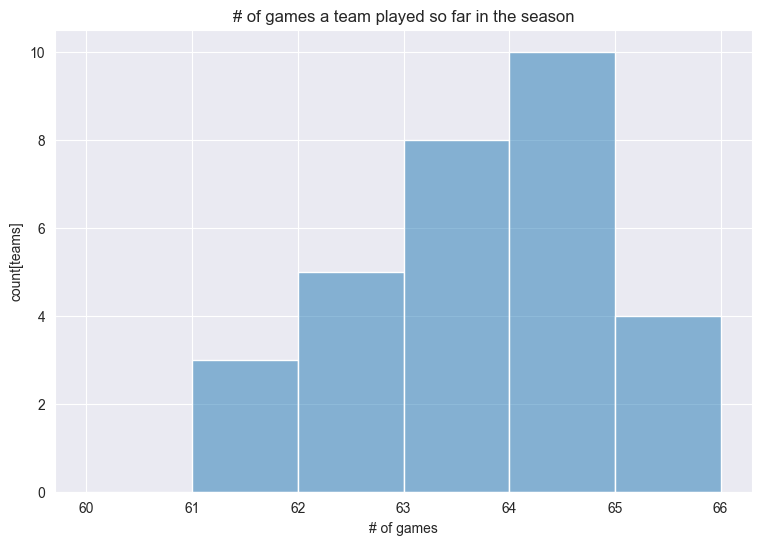

In [20]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    total_games, alpha=0.5, bins=np.arange(min(total_games) - 1, max(total_games) + 1)
)
ax.set(
    title="# of games a team played so far in the season",
    xlabel="# of games",
    ylabel="count[teams]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


#### __Histogram of number of players per game (for a single team) in the current season (2022-2023) so far__

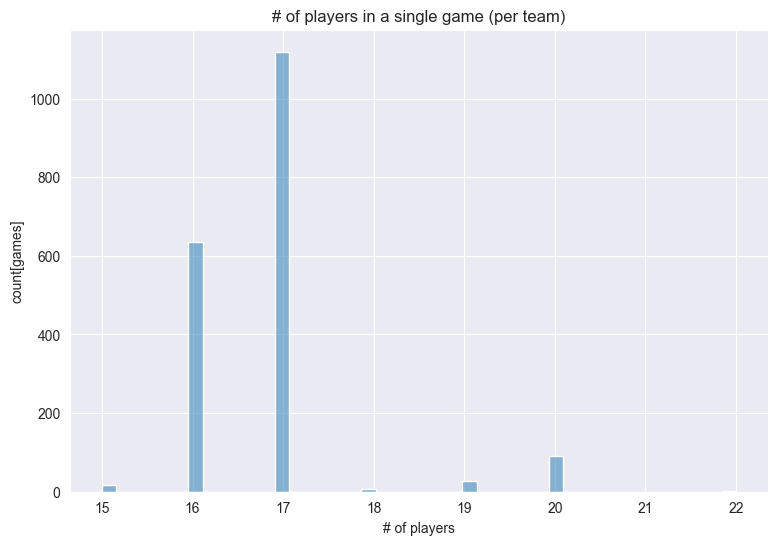

In [21]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_line_up.groupby(["GameID", "TeamID"]).count().to_numpy(), alpha=0.5
)
ax.set(
    title="# of players in a single game (per team)",
    xlabel="# of players",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


#### __Field goals__

__Histogram of field goals made out of field goals attempted in a single game per team in the current season (2022-2023) so far__

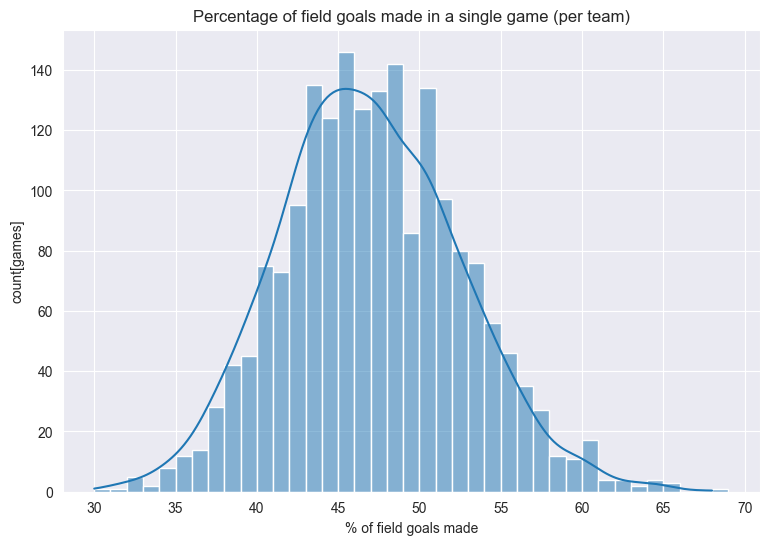

In [22]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["FGPER"].to_numpy(), alpha=0.5, kde=True, bins=np.arange(30, 70)
)
ax.set(
    title="Percentage of field goals made in a single game (per team)",
    xlabel="% of field goals made",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [23]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "FGPER"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="FGPER")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(
        i, teams_dict[index], "FG%", f"{team.values[0]:.2f}%"))


Team with highest FG% is Denver Nuggets - 50.50%
Team with 2nd highest FG% is Brooklyn Nets - 49.55%
Team with 3rd highest FG% is Minnesota Timberwolves - 48.73%


#### __Three points field goals__

__Histogram of three point field goal made out of attempted in a single game per team in the current season (2022-2023) so far__

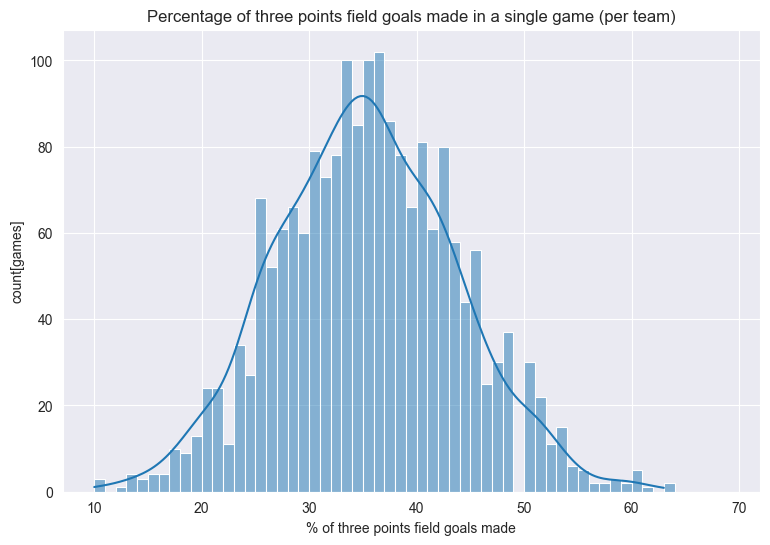

In [24]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["ThreePPER"].to_numpy(), alpha=0.5, kde=True, bins=np.arange(10, 70)
)
ax.set(
    title="Percentage of three points field goals made in a single game (per team)",
    xlabel="% of three points field goals made",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [25]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "ThreePPER"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="ThreePPER")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(
        i, teams_dict[index], "3FG%", f"{team.values[0]:.2f}%"))


Team with highest 3FG% is Denver Nuggets - 38.22%
Team with 2nd highest 3FG% is Brooklyn Nets - 38.19%
Team with 3rd highest 3FG% is Golden State Warriors - 37.75%


In [26]:
grouped = (
    game_player_score.to_pandas()
    .loc[:, ["PlayerID", "ThreePA", "ThreePPER"]]
    .groupby("PlayerID")
)
three_best_players = (
    grouped.filter(lambda x: x["ThreePA"].count() > 10)
    .loc[:, ["PlayerID", "ThreePPER"]]
    .groupby("PlayerID")
    .mean()
    .nlargest(3, columns="ThreePPER")
)
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(
        index_to_strings_players(
            i, players_dict[index], "3FG%", f"{player.values[0]:.2f}%"
        )
    )


Player with highest 3FG% is Buddy Hield - 41.80%
Player with 2nd highest 3FG% is Damion Lee - 41.14%
Player with 3rd highest 3FG% is Kentavious Caldwell-Pope - 39.19%


__Histogram of three point field goal made out of field goal made in a single game per team in the current season (2022-2023) so far__

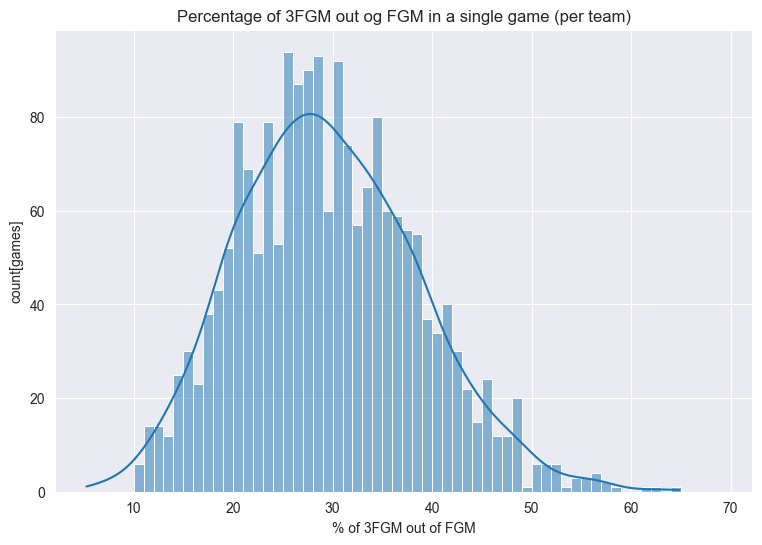

In [27]:
game_team_score["3FGM_to_FGM"] = (
    game_team_score["ThreePM"] * 100 / game_team_score["FGM"]
)
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["3FGM_to_FGM"].to_numpy(),
    alpha=0.5,
    kde=True,
    bins=np.arange(10, 70),
)
ax.set(
    title="Percentage of 3FGM out og FGM in a single game (per team)",
    xlabel="% of 3FGM out of FGM",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [28]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "3FGM_to_FGM"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="3FGM_to_FGM")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(
            i,
            teams_dict[index],
            "precentage of 3FGM out of FGM",
            f"{team.values[0]:.2f}%",
        )
    )


Team with highest precentage of 3FGM out of FGM is Boston Celtics - 38.47%
Team with 2nd highest precentage of 3FGM out of FGM is Dallas Mavericks - 38.12%
Team with 3rd highest precentage of 3FGM out of FGM is Golden State Warriors - 38.00%


#### __Free throws__

__Histogram of free throws made out of free throws attempted in a single game per team in the current season (2022-2023) so far__

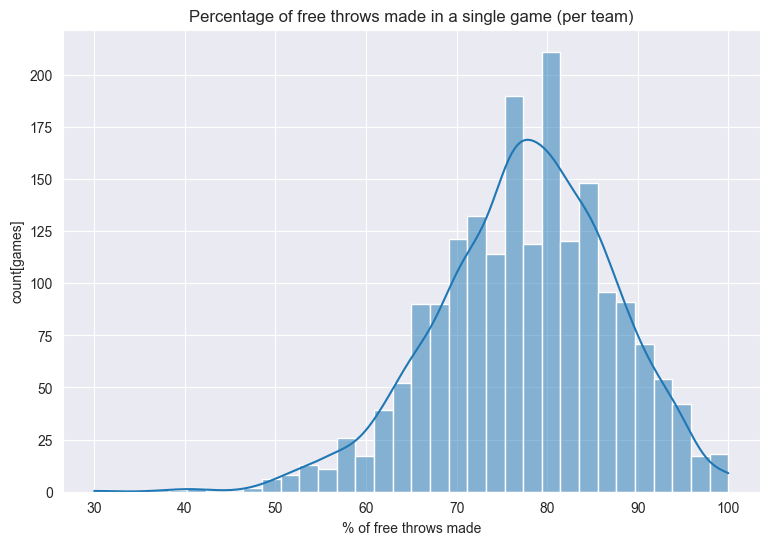

In [29]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(game_team_score["FTPER"].to_numpy(), alpha=0.5, kde=True)
ax.set(
    title="Percentage of free throws made in a single game (per team)",
    xlabel="% of free throws made",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [30]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "FTPER"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="FTPER")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(
        i, teams_dict[index], "FT%", f"{team.values[0]:.2f}%"))


Team with highest FT% is Philadelphia 76ers - 82.54%
Team with 2nd highest FT% is Boston Celtics - 82.25%
Team with 3rd highest FT% is Miami Heat - 82.16%


#### __Rebounds__

__Histogram of total rebounds in a single game per team in the current season (2022-2023) so far__

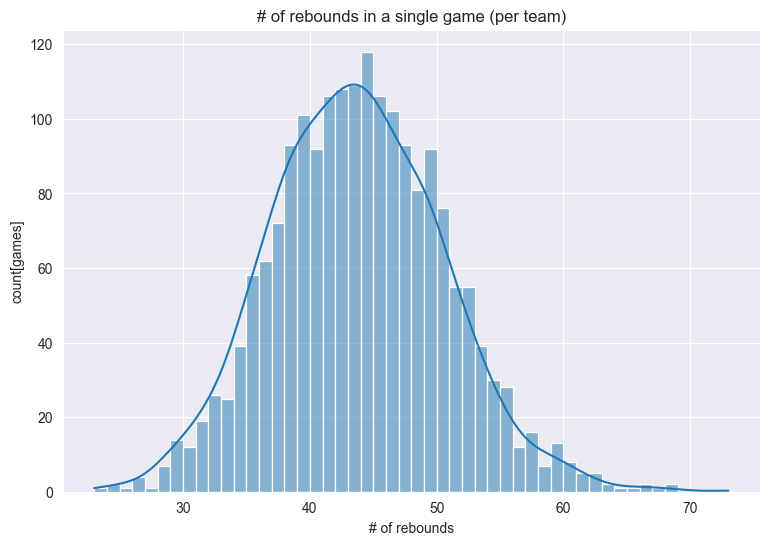

In [31]:
game_team_score["REB"] = game_team_score["OREB"] + game_team_score["DREB"]
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["REB"].to_numpy(), alpha=0.5, kde=True, bins=np.arange(23, 70)
)
ax.set(
    title="# of rebounds in a single game (per team)",
    xlabel="# of rebounds",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [32]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "REB"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="REB")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(
            i, teams_dict[index], "avg number of rebounds", f"{team.values[0]:.2f}"
        )
    )


Team with highest avg number of rebounds is Milwaukee Bucks - 48.83
Team with 2nd highest avg number of rebounds is Memphis Grizzlies - 47.66
Team with 3rd highest avg number of rebounds is New York Knicks - 47.17


In [33]:
game_player_score["REB"] = game_player_score["OREB"] + \
    game_player_score["DREB"]
three_best_players = (
    game_player_score.loc[:, ["PlayerID", "REB"]]
    .groupby(["PlayerID"])
    .mean()
    .nlargest(3, columns="REB")
)
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(
        index_to_strings_players(
            i, players_dict[index], "avg number of rebounds", f"{player.values[0]:.2f}"
        )
    )


Player with highest avg number of rebounds is Domantas Sabonis - 11.62
Player with 2nd highest avg number of rebounds is Nikola Vucevic - 11.33
Player with 3rd highest avg number of rebounds is Julius Randle - 10.52


__Histogram of offensive rebounds in a single game per team in the current season (2022-2023) so far__

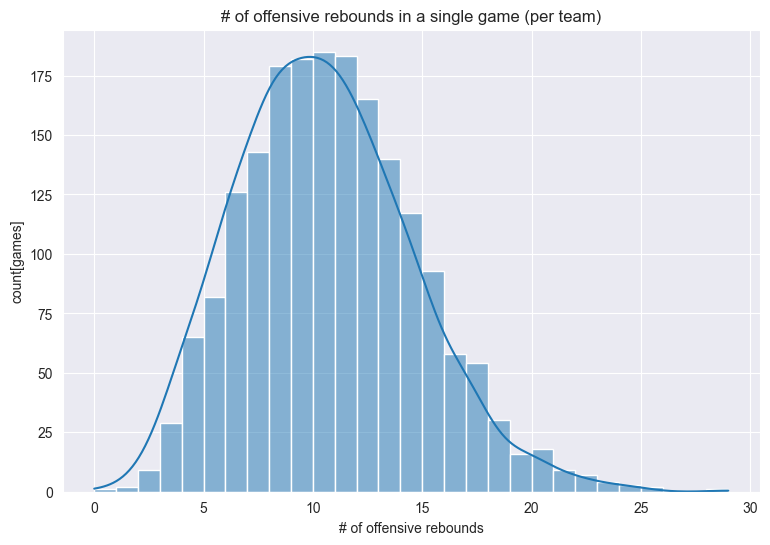

In [34]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["OREB"].to_numpy(), alpha=0.5, kde=True, bins=np.arange(0, 30)
)
ax.set(
    title="# of offensive rebounds in a single game (per team)",
    xlabel="# of offensive rebounds",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [35]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "OREB"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="OREB")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(
            i,
            teams_dict[index],
            "avg number of offensive rebounds",
            f"{team.values[0]:.2f}",
        )
    )


Team with highest avg number of offensive rebounds is Houston Rockets - 13.19
Team with 2nd highest avg number of offensive rebounds is New York Knicks - 12.89
Team with 3rd highest avg number of offensive rebounds is Toronto Raptors - 12.88


In [36]:
three_best_players = (
    game_player_score.loc[:, ["PlayerID", "OREB"]]
    .groupby(["PlayerID"])
    .mean()
    .nlargest(3, columns="OREB")
)
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(
        index_to_strings_players(
            i,
            players_dict[index],
            "avg number of offensive rebounds",
            f"{player.values[0]:.2f}",
        )
    )


Player with highest avg number of offensive rebounds is Steven Adams - 3.71
Player with 2nd highest avg number of offensive rebounds is Ivica Zubac - 3.08
Player with 3rd highest avg number of offensive rebounds is Mason Plumlee - 3.06


__Histogram of defensive rebounds in a single game per team in the current season (2022-2023) so far__

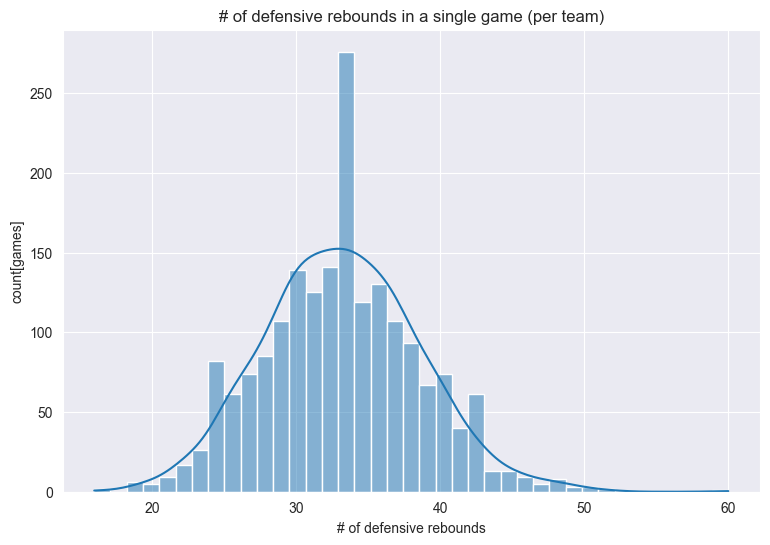

In [37]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(game_team_score["DREB"].to_numpy(), alpha=0.5, kde=True)
ax.set(
    title="# of defensive rebounds in a single game (per team)",
    xlabel="# of defensive rebounds",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [38]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "DREB"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="DREB")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(
            i,
            teams_dict[index],
            "avg number of defensive rebounds",
            f"{team.values[0]:.2f}",
        )
    )


Team with highest avg number of defensive rebounds is Milwaukee Bucks - 37.16
Team with 2nd highest avg number of defensive rebounds is Boston Celtics - 35.94
Team with 3rd highest avg number of defensive rebounds is Los Angeles Lakers - 35.92


In [39]:
three_best_players = (
    game_player_score.loc[:, ["PlayerID", "DREB"]]
    .groupby(["PlayerID"])
    .mean()
    .nlargest(3, columns="DREB")
)
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(
        index_to_strings_players(
            i,
            players_dict[index],
            "avg number of defensive rebounds",
            f"{player.values[0]:.2f}",
        )
    )


Player with highest avg number of defensive rebounds is Nikola Vucevic - 9.25
Player with 2nd highest avg number of defensive rebounds is Domantas Sabonis - 8.80
Player with 3rd highest avg number of defensive rebounds is Julius Randle - 8.47


#### __Asists__

__Histogram of assits in a single game per team in the current season (2022-2023) so far__

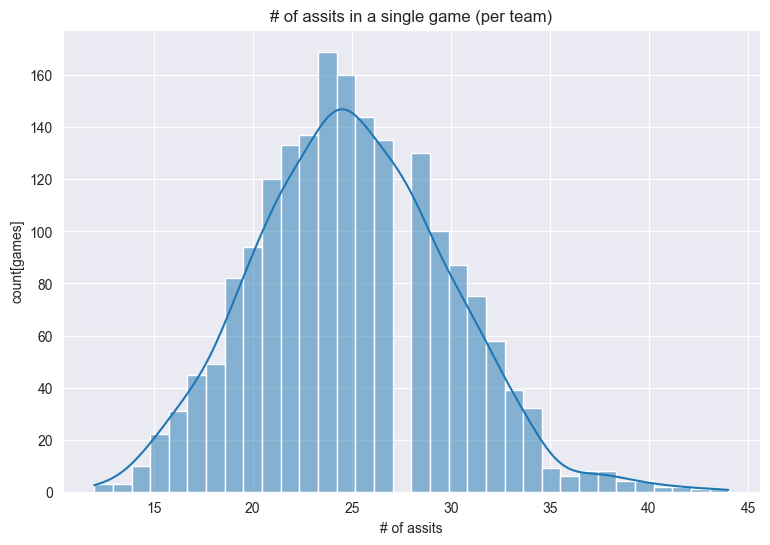

In [40]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(game_team_score["AST"].to_numpy(), alpha=0.5, kde=True)
ax.set(
    title="# of assits in a single game (per team)",
    xlabel="# of assits",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [41]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "AST"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="AST")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(i, teams_dict[index],
                         "avg of assits", f"{team.values[0]:.2f}")
    )


Team with highest avg of assits is Golden State Warriors - 29.65
Team with 2nd highest avg of assits is Denver Nuggets - 28.81
Team with 3rd highest avg of assits is Phoenix Suns - 27.02


#### __Blocks__

__Histogram of blocks in a single game per team in the current season (2022-2023) so far__

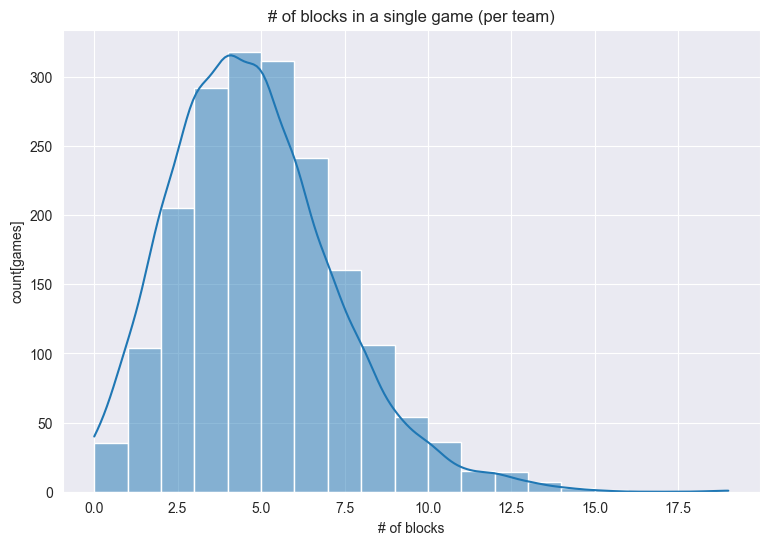

In [42]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["BLK"].to_numpy(), alpha=0.5, kde=True, bins=np.arange(0, 18)
)
ax.set(
    title="# of blocks in a single game (per team)",
    xlabel="# of blocks",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


In [43]:
three_best_teams = (
    game_team_score.loc[:, ["TeamID", "BLK"]]
    .groupby(["TeamID"])
    .mean()
    .nlargest(3, columns="BLK")
)
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(
        index_to_strings(i, teams_dict[index],
                         "avg of blocks", f"{team.values[0]:.2f}")
    )


Team with highest avg of blocks is Brooklyn Nets - 6.45
Team with 2nd highest avg of blocks is Indiana Pacers - 5.95
Team with 3rd highest avg of blocks is Memphis Grizzlies - 5.95


#### __Steals__

__Histogram of steals in a single game per team in the current season (2022-2023) so far__

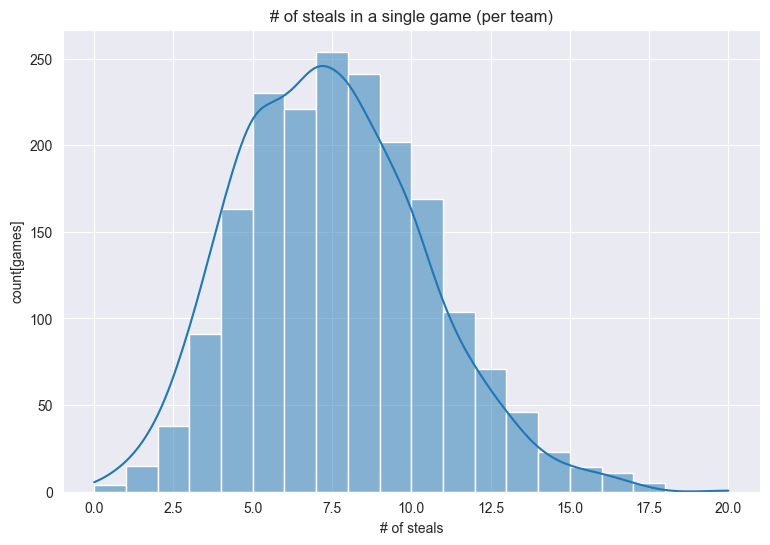

In [44]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["STL"].to_numpy(), alpha=0.5, kde=True, bins=20)
ax.set(
    title="# of steals in a single game (per team)",
    xlabel="# of steals",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


#### __Turnovers__

__Histogram of turnovers in a single game per team in the current season (2022-2023) so far__

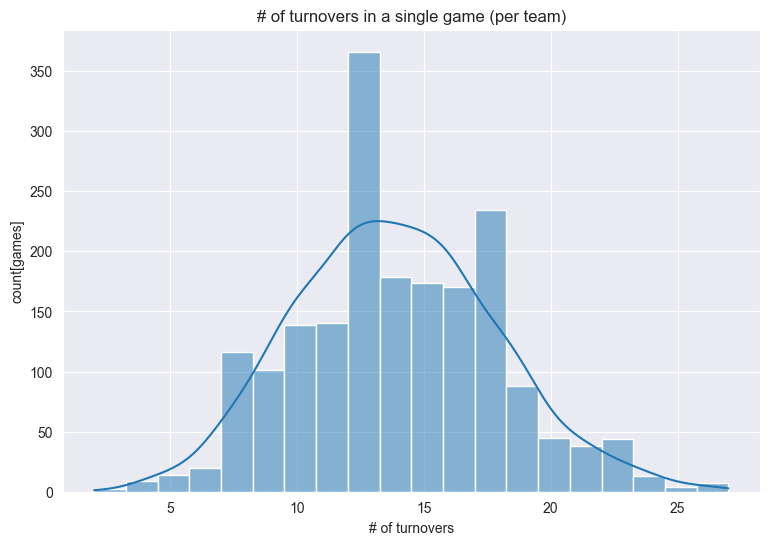

In [45]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    game_team_score["TournOvers"].to_numpy(), alpha=0.5, kde=True, bins=20
)
ax.set(
    title="# of turnovers in a single game (per team)",
    xlabel="# of turnovers",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)


#### __Teams recovery__

In [46]:
teams_recovery_3rd = {teamID: 0 for teamID in teams_dict.keys()}
teams_recovery_half = {teamID: 0 for teamID in teams_dict.keys()}

for i, row in finished_games.iterrows():
    visitor_team_pts_3rd = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["VisitorTeamID"]),
        "ScoreQThree",
    ].to_numpy()[0]
    home_team_pts_3rd = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["HomeTeamID"]),
        "ScoreQThree",
    ].to_numpy()[0]

    visitor_team_pts_half = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["VisitorTeamID"]),
        "ScoreQTwo",
    ].to_numpy()[0]
    home_team_pts_half = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["HomeTeamID"]),
        "ScoreQTwo",
    ].to_numpy()[0]

    visitor_team_pts = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["VisitorTeamID"]),
        "PTS",
    ].to_numpy()[0]
    home_team_pts = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["HomeTeamID"]),
        "PTS",
    ].to_numpy()[0]

    if (visitor_team_pts_3rd > home_team_pts_3rd) and (
        home_team_pts > visitor_team_pts
    ):
        teams_recovery_3rd[row["HomeTeamID"]] += 1

    if (visitor_team_pts_half > home_team_pts_half) and (
        home_team_pts > visitor_team_pts
    ):
        teams_recovery_half[row["HomeTeamID"]] += 1

    if (home_team_pts_3rd > visitor_team_pts_3rd) and (
        visitor_team_pts > home_team_pts
    ):
        teams_recovery_3rd[row["VisitorTeamID"]] += 1

    if (home_team_pts_half > visitor_team_pts_half) and (
        visitor_team_pts_half > home_team_pts_half
    ):
        teams_recovery_half[row["VisitorTeamID"]] += 1


__Number of games each team was behind in 3rd qurter and won__ 

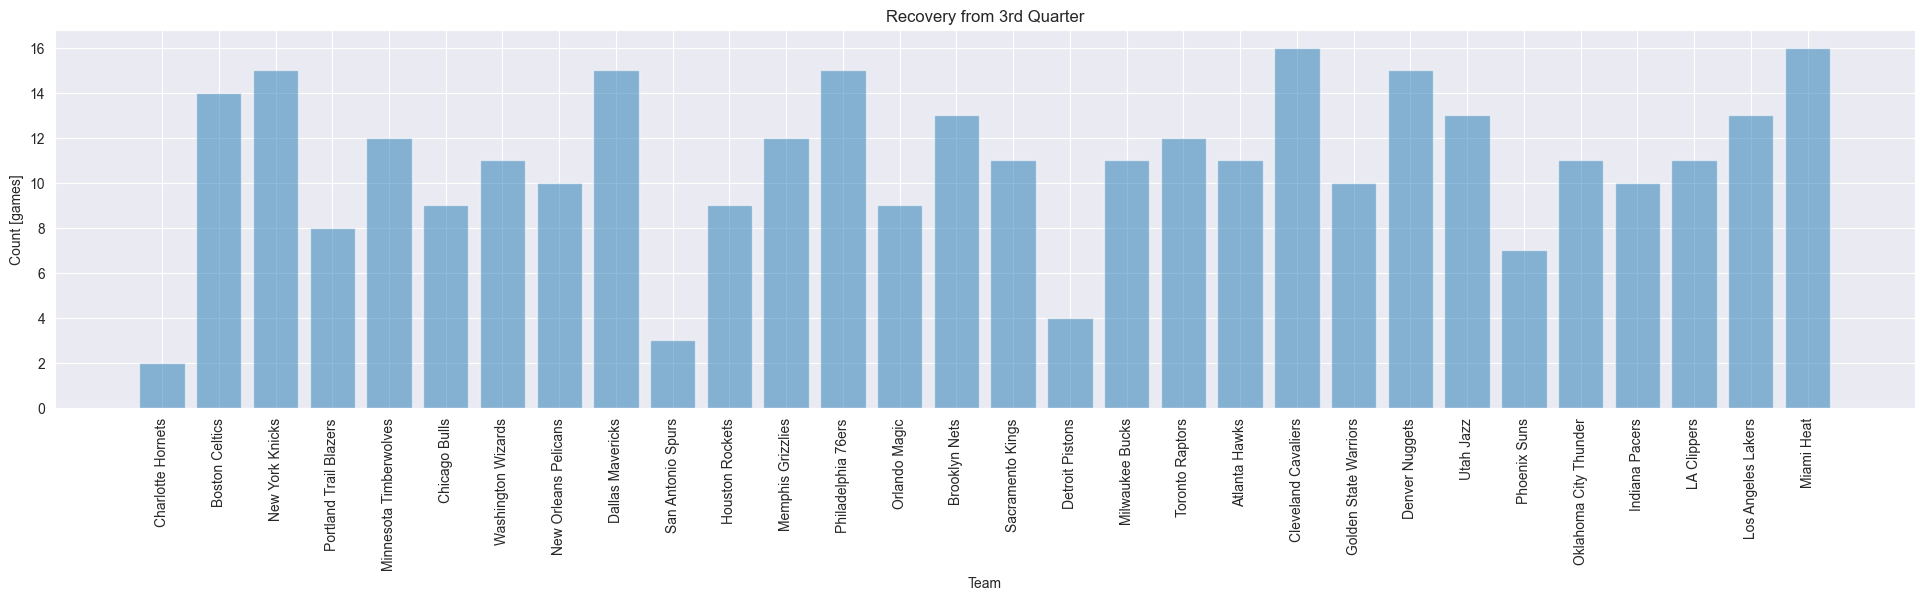

In [47]:
keys = [teams_dict[key] for key in teams_recovery_3rd.keys()]
values = teams_recovery_3rd.values()
fig, ax = plt.subplots(num=figure_count, figsize=(24, 6))
figure_count += 1
plt.subplots_adjust(right=0.9, top=0.9, bottom=0.27)
ax.bar(keys, values, alpha=0.5)
ax.set_xticks(range(len(keys)), keys, rotation=90)
ax.set_xlabel("Team")
ax.set_ylabel("Count [games]")
ax.set_title("Recovery from 3rd Quarter")
plt.show(fig)


__Number of games each team was behind in 2rd qurter and won__ 

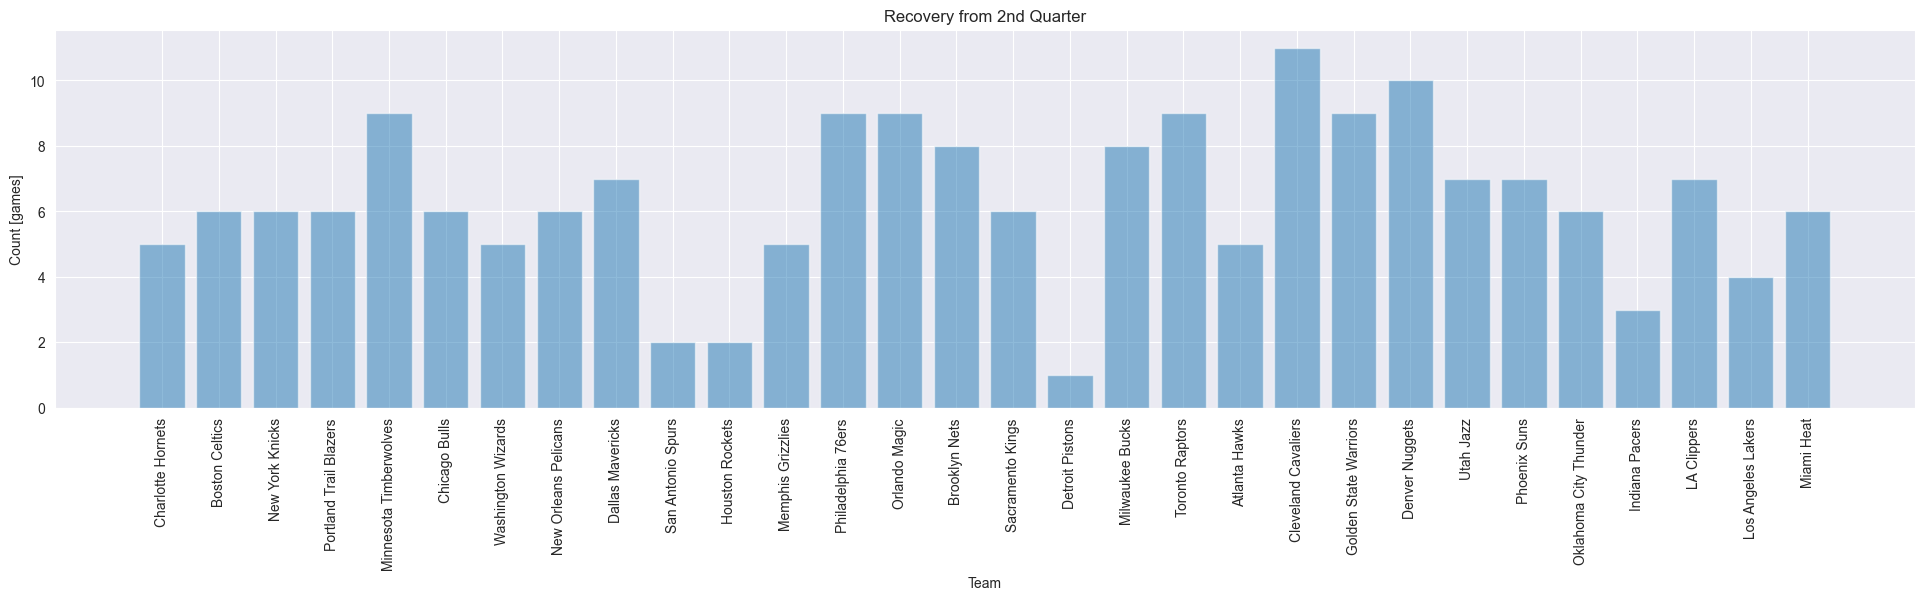

In [48]:
keys = [teams_dict[key] for key in teams_recovery_half.keys()]
values = teams_recovery_half.values()
fig, ax = plt.subplots(num=figure_count, figsize=(24, 6))
figure_count += 1
plt.subplots_adjust(right=0.9, top=0.9, bottom=0.27)
ax.bar(keys, values, alpha=0.5)
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel("Team")
ax.set_ylabel("Count [games]")
ax.set_title("Recovery from 2nd Quarter")
plt.show(fig)


#### __Teams "Power Ranking"__
__A measuremrnt we created to rank all teams, the ranking is composed of number of wins, AVG number of points, asists, steals, blocks and rebounds weighted differetly__

In [49]:
game_team_score_grouped = game_team_score.groupby(
    ["TeamID"]).mean().reset_index()


In [50]:
teams_wins = {teamID: 0 for teamID in teams_dict.keys()}
teams_losses = {teamID: 0 for teamID in teams_dict.keys()}


for i, row in finished_games.iterrows():
    visitor_team_pts = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["VisitorTeamID"]),
        "PTS",
    ].to_numpy()[0]
    home_team_pts = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == row["HomeTeamID"]),
        "PTS",
    ].to_numpy()[0]

    if visitor_team_pts > home_team_pts:
        teams_wins[row["VisitorTeamID"]] += 1
        teams_losses[row["HomeTeamID"]] += 1

    else:
        teams_wins[row["HomeTeamID"]] += 1
        teams_losses[row["VisitorTeamID"]] += 1

for key, value in teams_wins.items():
    game_team_score_grouped.loc[
        game_team_score_grouped["TeamID"] == key, "wins"
    ] = value


In [51]:
game_team_score_grouped["TeamScore"] = (
    0.2 * game_team_score_grouped["wins"]
    + 0.2 * game_team_score_grouped["PTS"]
    + 0.2 * game_team_score_grouped["AST"]
    + 0.1 * game_team_score_grouped["STL"]
    + 0.1 * game_team_score_grouped["BLK"]
    + 0.2 * game_team_score_grouped["REB"]
)


In [52]:
three_best_teams = game_team_score_grouped.nlargest(3, columns="TeamScore")
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[team["TeamID"]], "overall score", ""))


23/02/18 14:36:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Team with highest overall score is Boston Celtics - 
Team with 2nd highest overall score is Denver Nuggets - 
Team with 3rd highest overall score is Milwaukee Bucks - 


#### __Players "Power Ranking"__
__A measuremrnt we created to rank all players, the ranking is composed of AVG number of points, asists, steals, blocks and rebounds weighted differetly__

In [53]:
game_player_score_grouped = game_player_score.groupby(["PlayerID"]).mean()
game_player_score_grouped["PlayerScore"] = (
    0.4 * game_player_score_grouped["PTS"]
    + 0.2 * game_player_score_grouped["AST"]
    + 0.1 * game_player_score_grouped["STL"]
    + 0.1 * game_player_score_grouped["BLK"]
    + 0.2 * game_player_score_grouped["REB"]
)


In [54]:
three_best_players = game_player_score_grouped.nlargest(
    3, columns="PlayerScore")
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(
        i, players_dict[index], "overall score", ""))


Player with highest overall score is Luka Doncic - 
Player with 2nd highest overall score is Jayson Tatum - 
Player with 3rd highest overall score is Julius Randle - 


## Team level analysis
### seleceted team - Phoenix Suns

In [55]:
# Change selected team here
selected_team_ID = teams_names_dict["Phoenix Suns"]


In [56]:
selected_team_games = finished_games.loc[
    (finished_games["HomeTeamID"] == selected_team_ID)
    | (finished_games["VisitorTeamID"] == selected_team_ID),
    :,
]

for i, row in selected_team_games.iterrows():
    if row["HomeTeamID"] == selected_team_ID:
        home = True
        selected_team_games.loc[selected_team_games["ID"]
                                == row["ID"], "home"] = True
    else:
        home = False
        selected_team_games.loc[selected_team_games["ID"]
                                == row["ID"], "home"] = False

    selected_team_pts = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == selected_team_ID),
        "PTS",
    ].to_numpy()[0]

    # Fill the df with stats from the game
    selected_team_games.loc[
        selected_team_games["ID"] == row["ID"], "PTS"
    ] = selected_team_pts
    selected_team_games.loc[
        selected_team_games["ID"] == row["ID"], "FGPER"
    ] = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == selected_team_ID),
        "FGPER",
    ].to_numpy()[
        0
    ]
    selected_team_games.loc[
        selected_team_games["ID"] == row["ID"], "ThreePPER"
    ] = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == selected_team_ID),
        "ThreePPER",
    ].to_numpy()[
        0
    ]
    selected_team_games.loc[
        selected_team_games["ID"] == row["ID"], "3FGM_to_FGM"
    ] = game_team_score.loc[
        (game_team_score["GameID"] == row["ID"])
        & (game_team_score["TeamID"] == selected_team_ID),
        "3FGM_to_FGM",
    ].to_numpy()[
        0
    ]

    if home:
        other_team_pts = game_team_score.loc[
            (game_team_score["GameID"] == row["ID"])
            & (game_team_score["TeamID"] == row["VisitorTeamID"]),
            "PTS",
        ].to_numpy()[0]
    else:
        other_team_pts = game_team_score.loc[
            (game_team_score["GameID"] == row["ID"])
            & (game_team_score["TeamID"] == row["HomeTeamID"]),
            "PTS",
        ].to_numpy()[0]

    if other_team_pts > selected_team_pts:
        selected_team_games.loc[selected_team_games["ID"]
                                == row["ID"], "result"] = "L"
    else:
        selected_team_games.loc[selected_team_games["ID"]
                                == row["ID"], "result"] = "W"


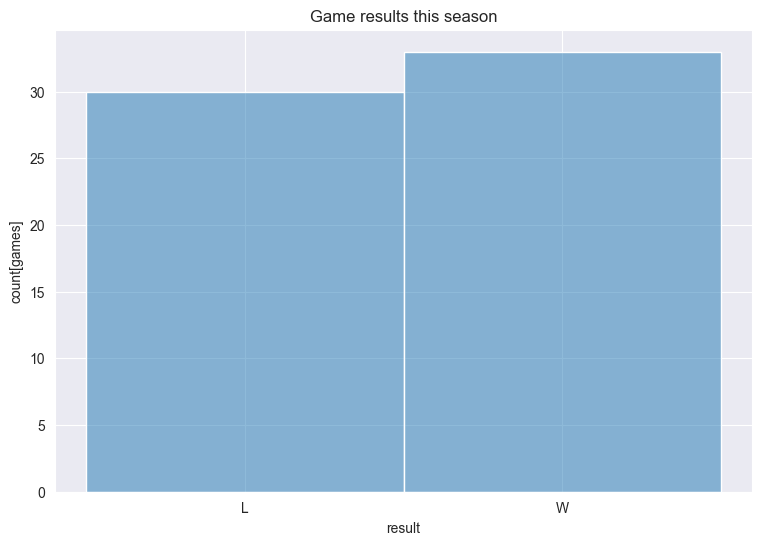

In [57]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    selected_team_games["result"].to_numpy(), alpha=0.5, bins=[-0.5, 0.5, 1.5]
)
ax.set(title="Game results this season",
       xlabel="result", ylabel="count[games]")
plt.legend([], [], frameon=False)
plt.show(fig)


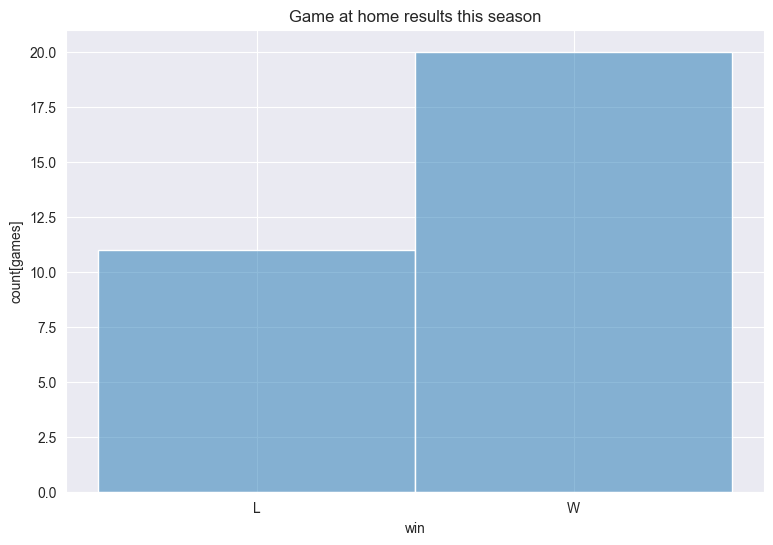

In [58]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    selected_team_games.loc[selected_team_games["home"]
                            == True, "result"].to_numpy(),
    alpha=0.5,
    bins=[-0.5, 0.5, 1.5],
)
ax.set(title="Game at home results this season",
       xlabel="win", ylabel="count[games]")
plt.legend([], [], frameon=False)
plt.show(fig)


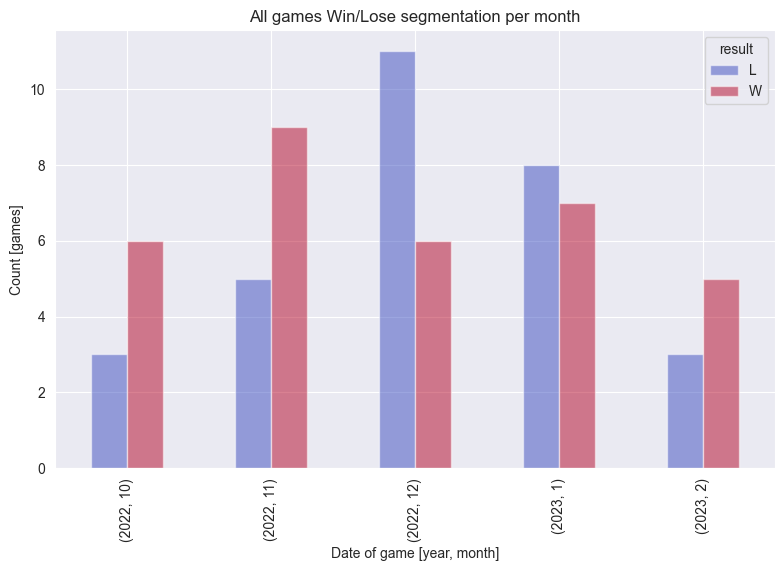

In [59]:
selected_team_games_copy = selected_team_games.to_pandas().set_index("Date")

line_plot = selected_team_games_copy.home

line_plot2 = selected_team_games_copy.result

bar_plot = (
    line_plot.groupby(
        [line_plot.index.year, line_plot.index.month, line_plot2])
    .count()
    .unstack()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("Count [games]")
ax.set_title("All games Win/Lose segmentation per month")
plt.show(fig)


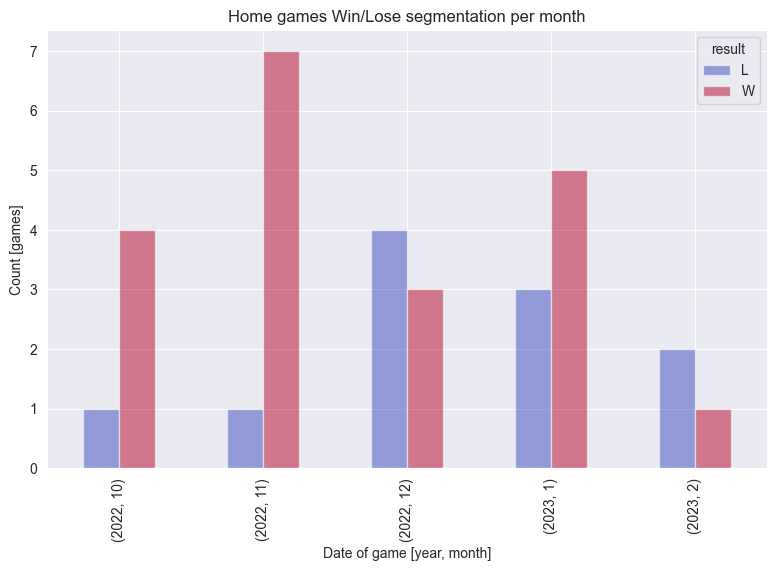

In [60]:
home_games = selected_team_games["home"] == True
selected_team_games_at_home_copy = (
    selected_team_games.loc[home_games, :].to_pandas().set_index("Date")
)

line_plot = selected_team_games_at_home_copy.home

line_plot2 = selected_team_games_at_home_copy.result

bar_plot = (
    line_plot.groupby(
        [line_plot.index.year, line_plot.index.month, line_plot2])
    .count()
    .unstack()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("Count [games]")
ax.set_title("Home games Win/Lose segmentation per month")
plt.show(fig)


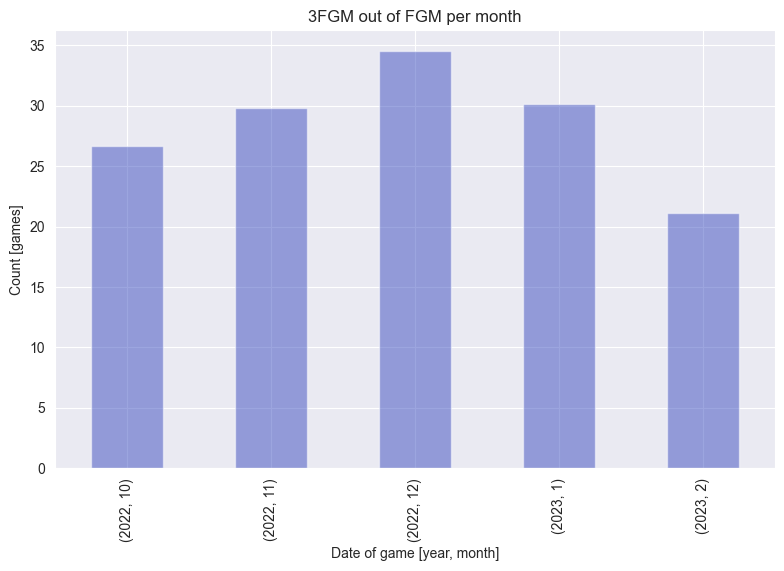

In [61]:
line_plot = selected_team_games_copy.home

bar_plot = (
    selected_team_games_copy["3FGM_to_FGM"]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("Count [games]")
ax.set_title("3FGM out of FGM per month")
plt.show(fig)


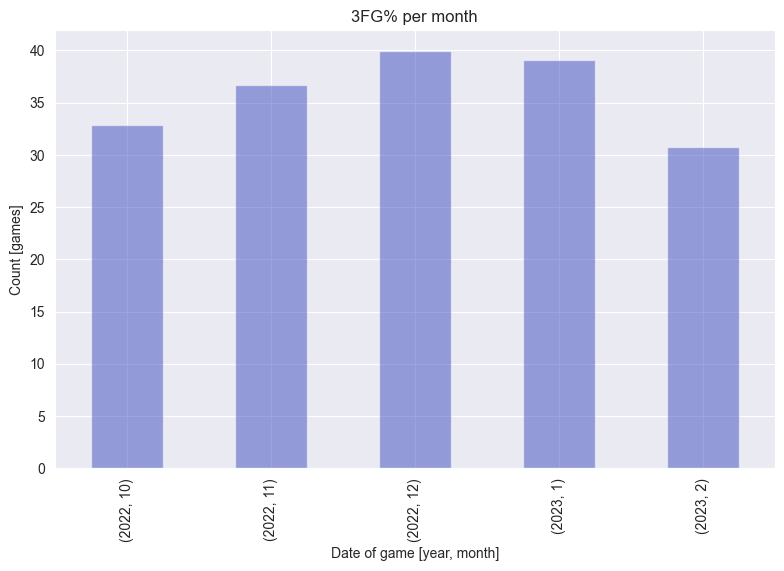

In [62]:
bar_plot = (
    selected_team_games_copy["ThreePPER"]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("Count [games]")
ax.set_title("3FG% per month")
plt.show(fig)


In [63]:
grouped = pd.DataFrame(
    game_line_up.loc[game_line_up["TeamID"] ==
                     selected_team_ID, ["GameID", "PlayerID"]]
    .to_pandas()
    .groupby("GameID")["PlayerID"]
    .apply(list)
)
for gameID in grouped.index:
    grouped.loc[gameID, "result"] = selected_team_games.loc[
        selected_team_games["ID"] == gameID, "result"
    ].to_numpy()[0]


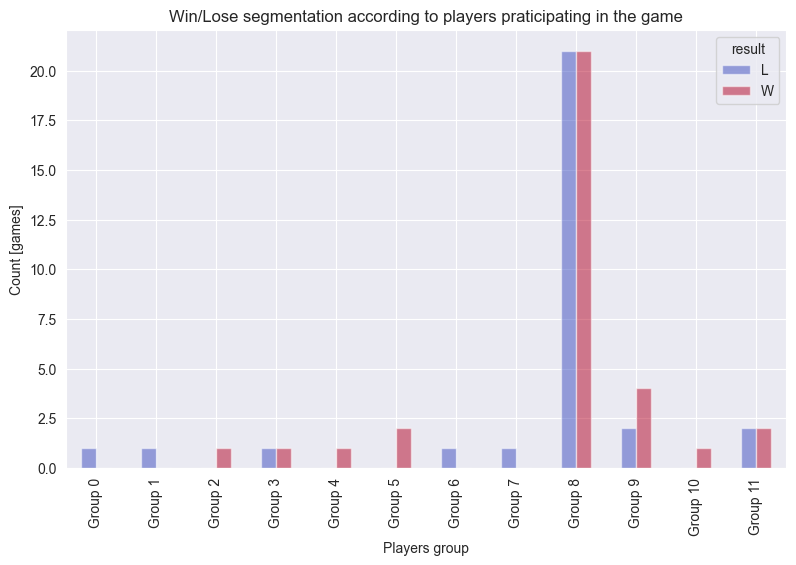

In [64]:
grouped["PlayerID"] = grouped.PlayerID.apply(tuple)
bar_plot = (
    grouped.reset_index().groupby(["PlayerID", "result"])[
        "GameID"].count().unstack()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Players group")
ax.set_ylabel("Count [games]")
ax.set_title(
    "Win/Lose segmentation according to players praticipating in the game")
ax.set_xticklabels([f"Group {i}" for i in range(len(ax.get_xticks()))])
plt.show(fig)


In [65]:
for i, group_players in enumerate(bar_plot.index):
    print(f"Players in group {i}:")
    print([players_dict.get(player) for player in group_players])


Players in group 0:
['Torrey Craig', 'T.J. Warren', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre Ayton', 'Kevin Durant', 'Saben Lee']
Players in group 1:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Terrence Ross', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'T.J. Warren', 'Deandre Ayton', 'Kevin Durant', 'Saben Lee', 'Darius Bazley']
Players in group 2:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'T.J. Warren', 'Deandre Ayton', 'Kevin Durant', 'Saben Lee', 'Darius Bazley']
Players in group 3:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre

In [66]:
selected_team_players = team_rosters.loc[
    team_rosters["TeamID"] == selected_team_ID, "PlayerID"
].to_numpy()
selected_team_game_player_score = game_player_score.loc[
    game_player_score["PlayerID"].isin(selected_team_players), :
]


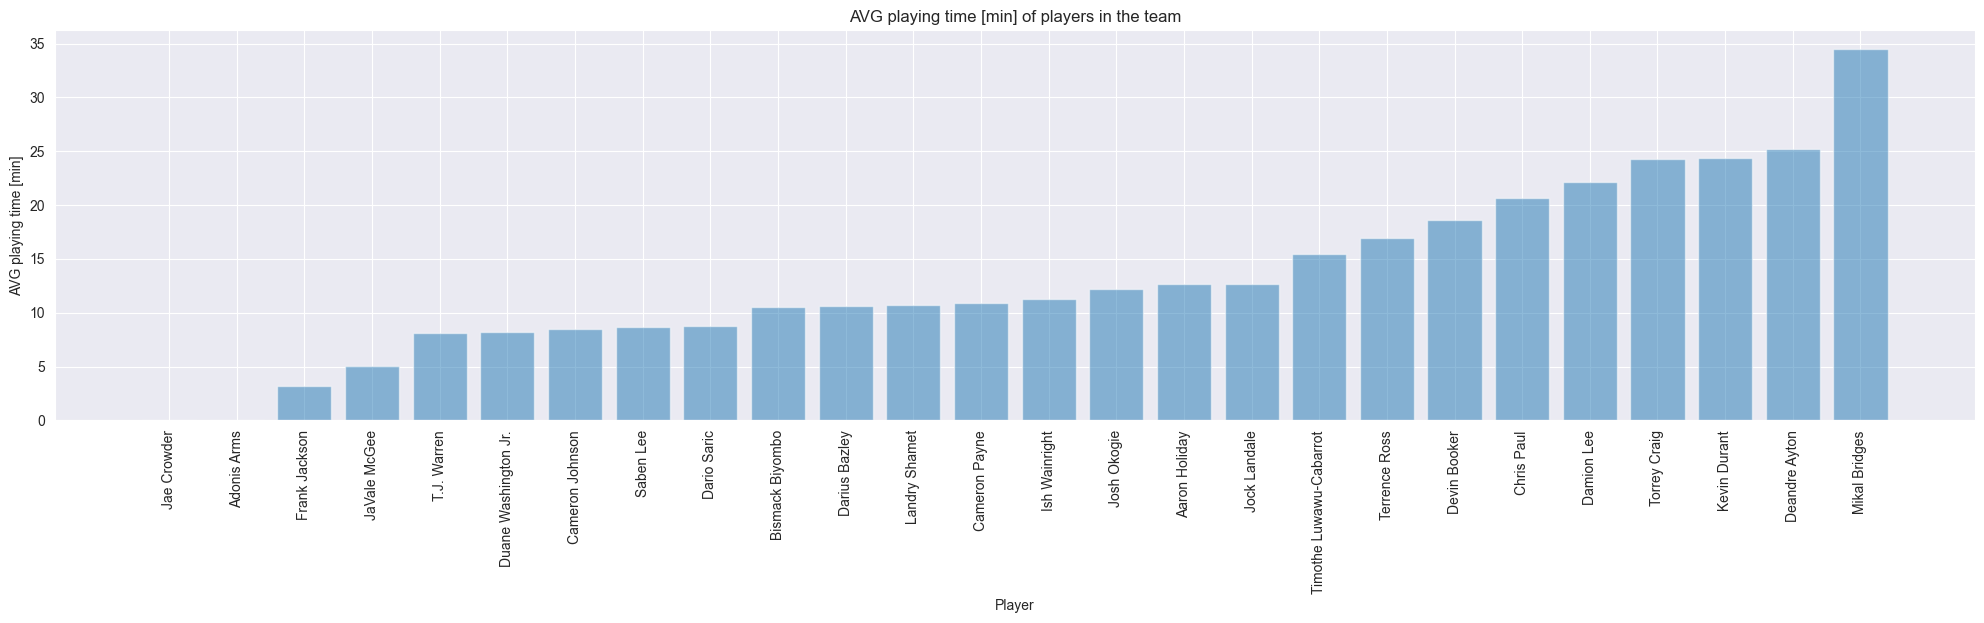

In [67]:
selected_team_game_player_score_grouped = (
    selected_team_game_player_score.groupby("PlayerID")
    .mean()
    .sort_values("PlayTimeInSec")
)

keys = [
    players_dict[player]
    for player in selected_team_game_player_score_grouped.index.to_numpy()
]
values = selected_team_game_player_score_grouped["PlayTimeInSec"].to_numpy(
) / 60

fig, ax = plt.subplots(num=figure_count, figsize=(24, 6))
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
ax.bar(
    keys,
    values,
    alpha=0.5,
)
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel("Player")
ax.set_ylabel("AVG playing time [min]")
ax.set_title("AVG playing time [min] of players in the team")
plt.show(fig)


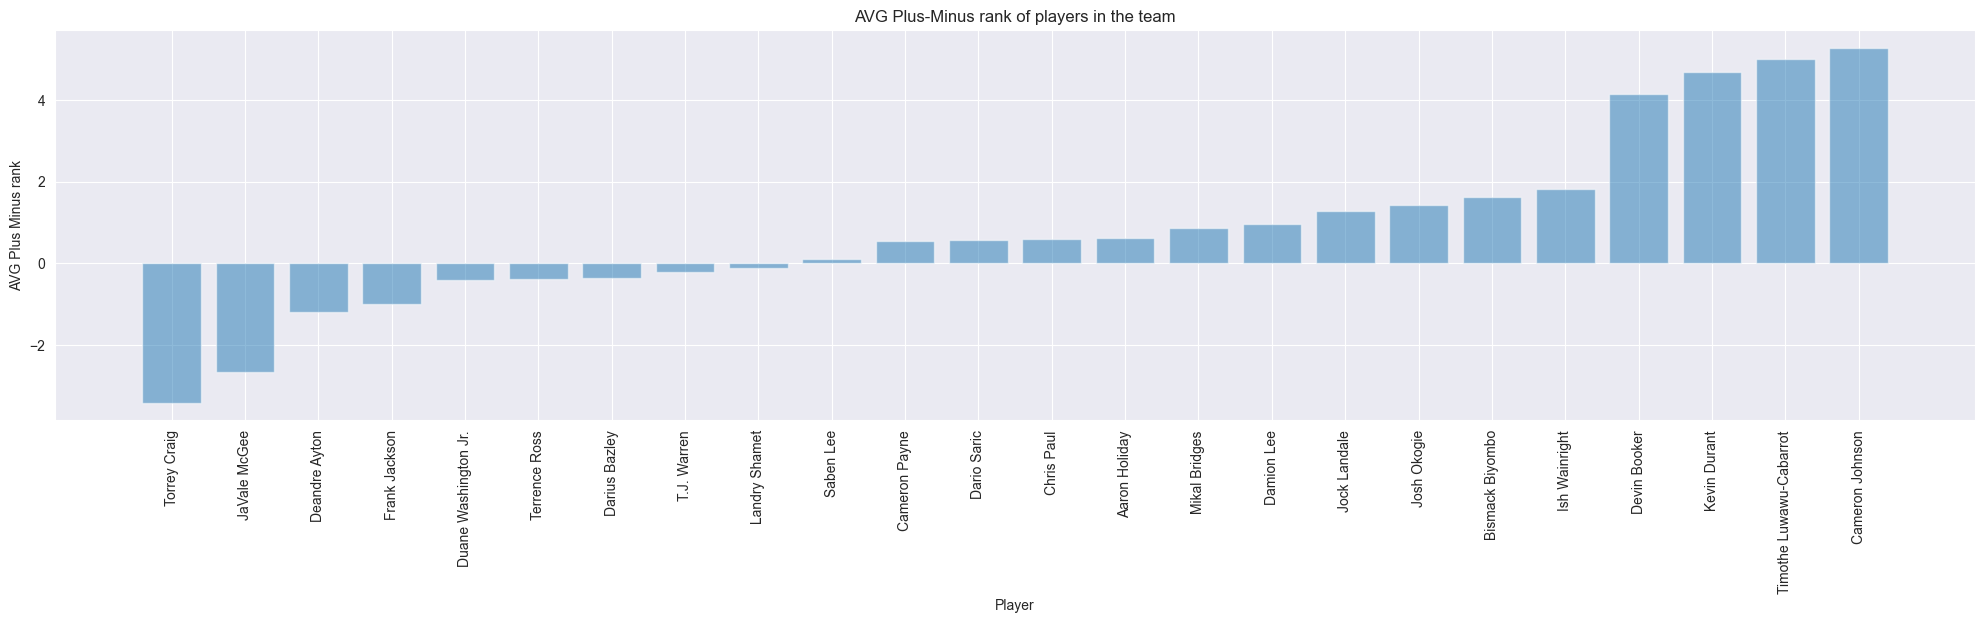

In [68]:
selected_team_game_player_score_grouped = (
    selected_team_game_player_score.loc[game_player_score["PlayTimeInSec"] > 240, :]
    .groupby("PlayerID")
    .mean()
    .sort_values("PlusMinusRank")
)

keys = [
    players_dict[player]
    for player in selected_team_game_player_score_grouped.index.to_numpy()
]
values = selected_team_game_player_score_grouped["PlusMinusRank"].to_numpy()

fig, ax = plt.subplots(num=figure_count, figsize=(24, 6))
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
ax.bar(keys, values, alpha=0.5)
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel("Player")
ax.set_ylabel("AVG Plus Minus rank")
ax.set_title("AVG Plus-Minus rank of players in the team")
plt.show(fig)


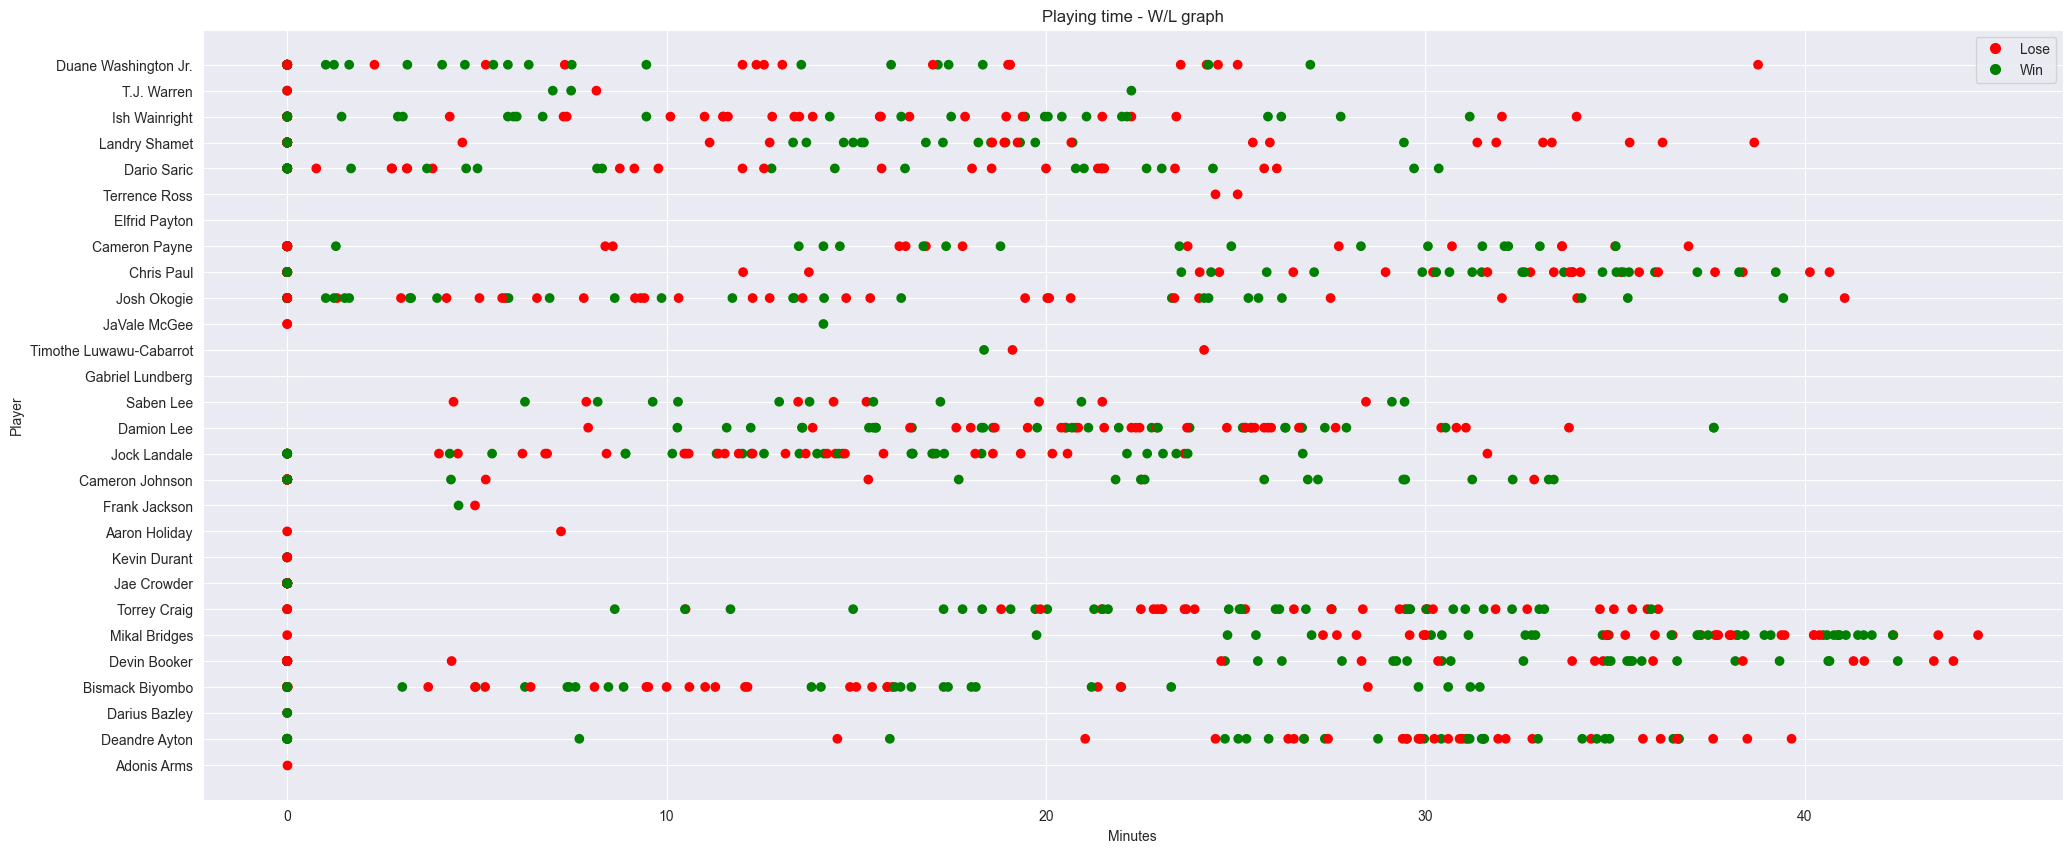

In [69]:
fig, ax = plt.subplots(num=figure_count, figsize=(24, 10))
figure_count += 1

rows_count = 0
for player_id in selected_team_players:
    player_games = selected_team_game_player_score.loc[
        selected_team_game_player_score["PlayerID"] == int(player_id),
        ["PlayerID", "GameID", "PlayTimeInSec"],
    ]
    player_games["PlayTimeInSec"] = player_games["PlayTimeInSec"] / 60
    player_games = ps.merge(
        player_games, selected_team_games, left_on=["GameID"], right_on=["ID"]
    )

    scatter = plt.scatter(
        x=player_games["PlayTimeInSec"].to_numpy(),
        y=np.ones(player_games.shape[0]) * rows_count,
        c=["green" if x == "W" else "red" for x in player_games["result"].to_numpy()],
    )

    rows_count += 4

ax.set_yticks(
    range(0, 4 * len(selected_team_players), 4),
    [players_dict[player] for player in selected_team_players],
)
ax.set_xlabel("Minutes")
ax.set_ylabel("Player")
ax.set_title("Playing time - W/L graph")

red = mlines.Line2D(
    [],
    [],
    color="red",
    marker="o",
    markersize=7,
    label="Lose",
    linewidth=0,
)
green = mlines.Line2D(
    [],
    [],
    color="green",
    marker="o",
    markersize=7,
    label="Win",
    linewidth=0,
)
ax.legend(handles=[red, green])
plt.show(fig)


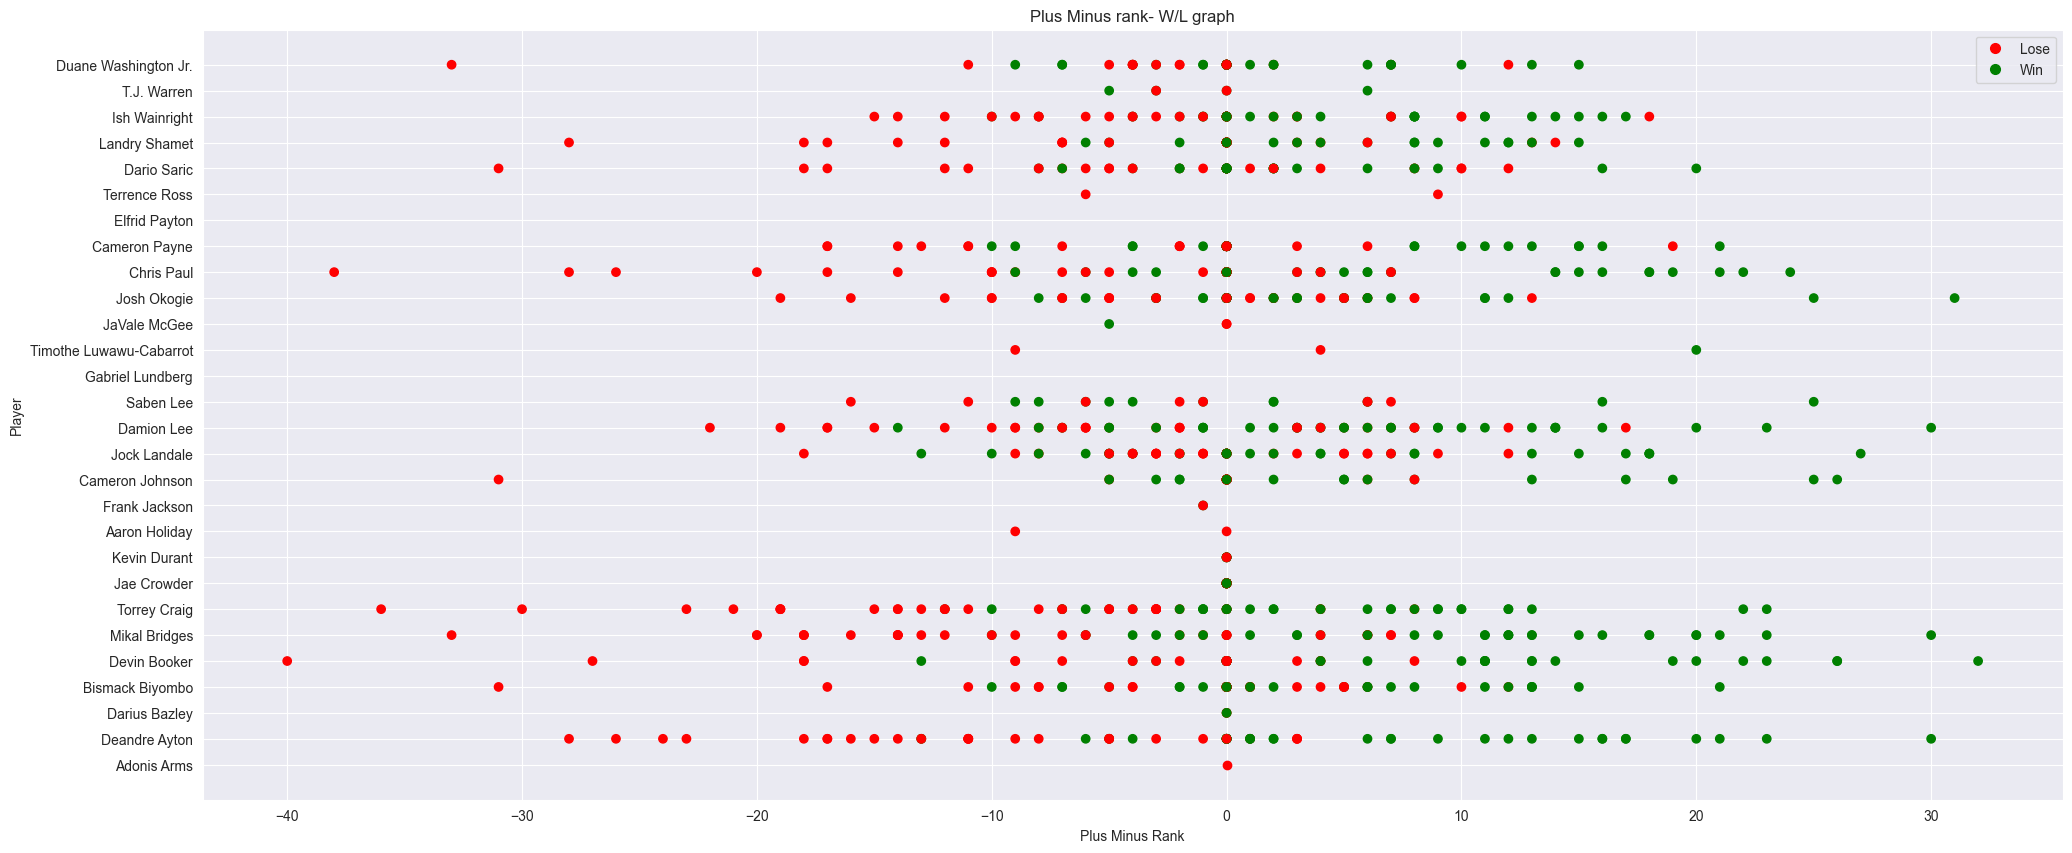

In [70]:
fig, ax = plt.subplots(num=figure_count, figsize=(24, 10))
figure_count += 1

rows_count = 0
for player_id in selected_team_players:
    player_games = selected_team_game_player_score.loc[
        selected_team_game_player_score["PlayerID"] == int(player_id),
        ["PlayerID", "GameID", "PlusMinusRank"],
    ]
    player_games = ps.merge(
        player_games, selected_team_games, left_on=["GameID"], right_on=["ID"]
    )

    scatter = plt.scatter(
        x=player_games["PlusMinusRank"].to_numpy(),
        y=np.ones(player_games.shape[0]) * rows_count,
        c=["green" if x == "W" else "red" for x in player_games["result"].to_numpy()],
    )

    rows_count += 4

ax.set_yticks(
    range(0, 4 * len(selected_team_players), 4),
    [players_dict[player] for player in selected_team_players],
)
ax.set_xlabel("Plus Minus Rank")
ax.set_ylabel("Player")
ax.set_title("Plus Minus rank- W/L graph")

red = mlines.Line2D(
    [],
    [],
    color="red",
    marker="o",
    markersize=7,
    label="Lose",
    linewidth=0,
)
green = mlines.Line2D(
    [],
    [],
    color="green",
    marker="o",
    markersize=7,
    label="Win",
    linewidth=0,
)
ax.legend(handles=[red, green])
plt.show(fig)


## Player level analysis
### seleceted player - Deni Avdija

In [71]:
# Change selected player here
selected_player_id = players_names_dict["Deni Avdija"]


In [72]:
selected_player_games = game_player_score.loc[
    game_player_score["PlayerID"] == selected_player_id, :
]
selected_player_games["PlayTimeInMin"] = selected_player_games["PlayTimeInSec"] / 60
selected_player_games = ps.merge(
    selected_player_games, games, left_on=["GameID"], right_on=["ID"]
)


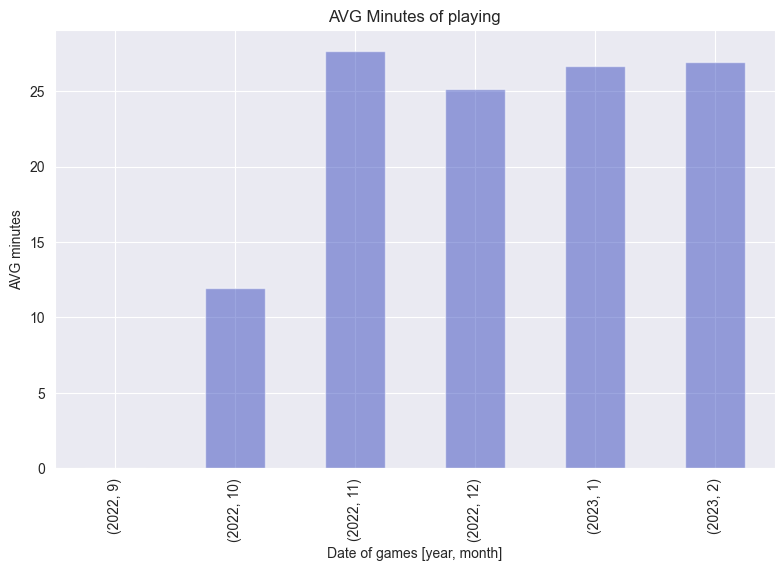

In [73]:
selected_player_games_pd = selected_player_games.to_pandas().set_index("Date")
line_plot = selected_player_games_pd.AST

bar_plot = (
    selected_player_games_pd["PlayTimeInMin"]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of games [year, month]")
ax.set_ylabel("AVG minutes")
ax.set_title("AVG Minutes of playing")
plt.show(fig)


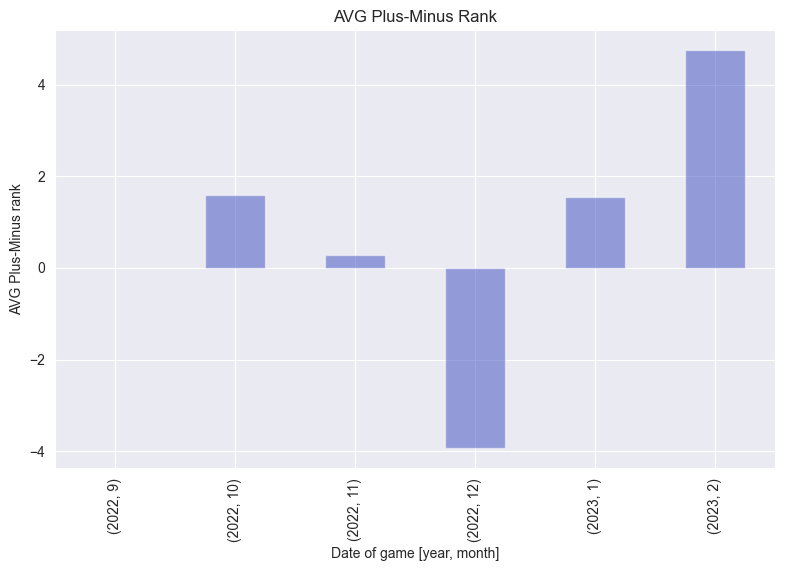

In [74]:
bar_plot = (
    selected_player_games_pd["PlusMinusRank"]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax=ax, kind="bar", figsize=(
    9, 6), colormap="coolwarm", alpha=0.5)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("AVG Plus-Minus rank")
ax.set_title("AVG Plus-Minus Rank")
plt.show(fig)


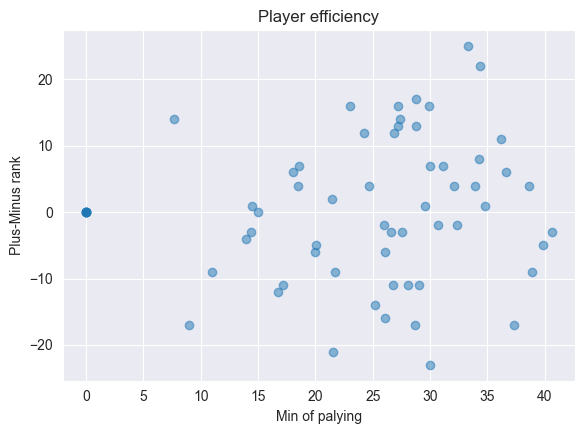

In [75]:
fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
plt.scatter(
    x=selected_player_games_pd["PlayTimeInMin"],
    y=selected_player_games_pd["PlusMinusRank"],
    alpha=0.5,
)
ax.set_xlabel("Min of palying")
ax.set_ylabel("Plus-Minus rank")
ax.set_title("Player efficiency")
plt.show(fig)

The above graph can help us estimate the ration between Plus-Minus rank and minutes of playing of the selected player

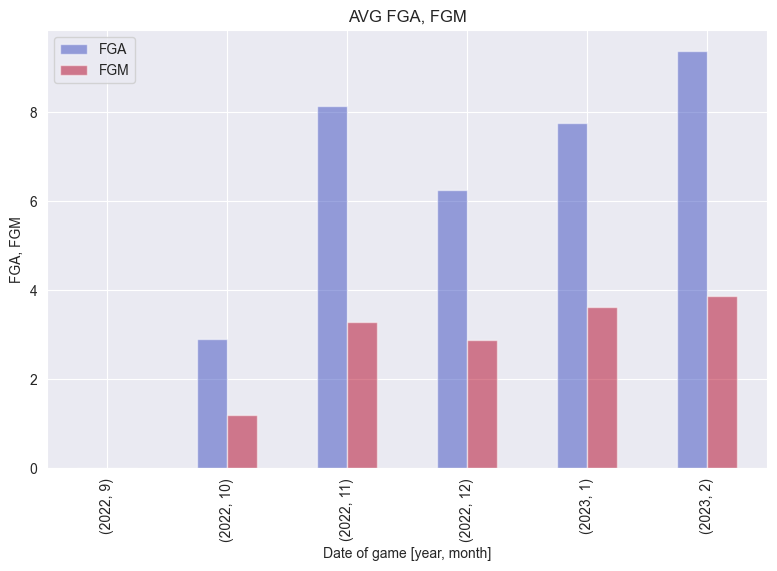

In [76]:
bar_plot = (
    selected_player_games_pd.loc[:, ["FGA", "FGM"]]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(
    ax=ax,
    kind="bar",
    figsize=(9, 6),
    colormap="coolwarm",
    alpha=0.5,
    legend=["3FGA", "3FGM"],
)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("FGA, FGM")
ax.set_title("AVG FGA, FGM")
plt.show(fig)

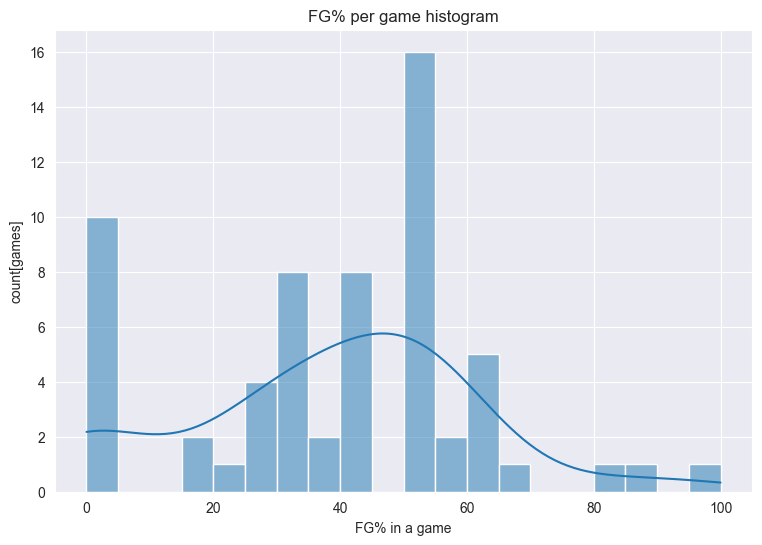

In [77]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    selected_player_games_pd["FGPER"].to_numpy(), alpha=0.5, kde=True, bins=20
)
ax.set(title="FG% per game histogram", xlabel="FG% in a game", ylabel="count[games]")
plt.legend([], [], frameon=False)
plt.show(fig)

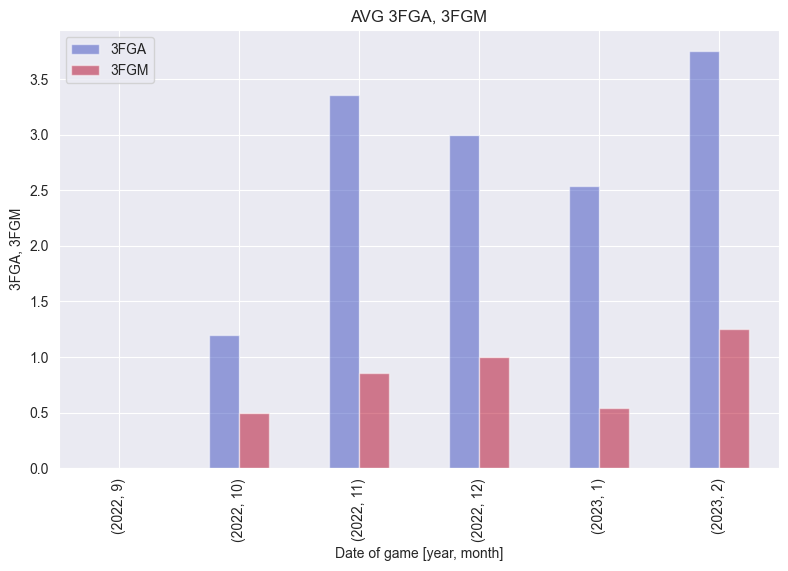

In [78]:
bar_plot = (
    selected_player_games_pd.loc[:, ["ThreePA", "ThreePM"]]
    .groupby([line_plot.index.year, line_plot.index.month])
    .mean()
)

fig, ax = plt.subplots(num=figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(
    ax=ax,
    kind="bar",
    figsize=(9, 6),
    colormap="coolwarm",
    alpha=0.5,
    legend=["3FGA", "3FGM"],
)
ax.set_xlabel("Date of game [year, month]")
ax.set_ylabel("3FGA, 3FGM")
ax.set_title("AVG 3FGA, 3FGM")
ax.legend(["3FGA", "3FGM"])
plt.show(fig)

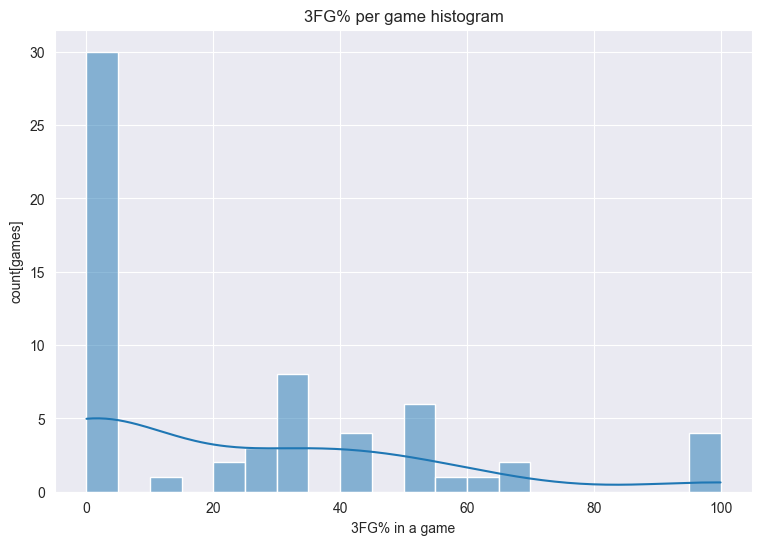

In [79]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    selected_player_games_pd["ThreePPER"].to_numpy(), alpha=0.5, kde=True, bins=20
)
ax.set(title="3FG% per game histogram", xlabel="3FG% in a game", ylabel="count[games]")
plt.legend([], [], frameon=False)
plt.show(fig)

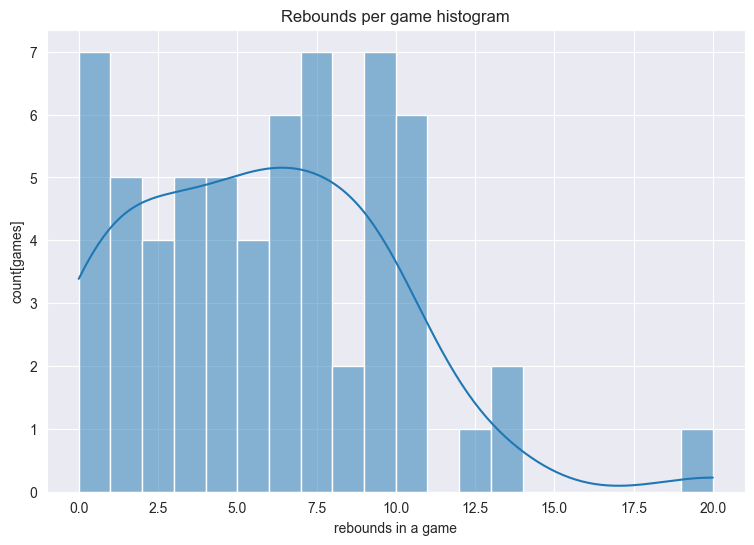

In [80]:
fig = plt.figure(figure_count, figsize=(9, 6))
figure_count += 1
ax = sns.histplot(
    selected_player_games_pd["REB"].to_numpy(), alpha=0.5, kde=True, bins=20
)
ax.set(
    title="Rebounds per game histogram",
    xlabel="rebounds in a game",
    ylabel="count[games]",
)
plt.legend([], [], frameon=False)
plt.show(fig)

## Predict game results
### Dataset creation

In [81]:
prediction_dataset = games.loc[:, ["ID", "Date", "HomeTeamID", "VisitorTeamID"]].copy()
prediction_dataset = (
    ps.merge(
        prediction_dataset,
        game_team_score[["GameID", "TeamID", "PTS"]],
        left_on=["ID", "HomeTeamID"],
        right_on=["GameID", "TeamID"],
    )
    .drop(columns=["GameID", "TeamID"])
    .rename(columns={"PTS": "HomeTeamPTS"})
)
prediction_dataset = (
    ps.merge(
        prediction_dataset,
        game_team_score[["GameID", "TeamID", "PTS"]],
        left_on=["ID", "VisitorTeamID"],
        right_on=["GameID", "TeamID"],
    )
    .drop(columns=["GameID", "TeamID"])
    .rename(columns={"PTS": "VisitorTeamPTS"})
)
prediction_dataset["HomeTeamWin"] = (
    prediction_dataset["HomeTeamPTS"] > prediction_dataset["VisitorTeamPTS"]
)
prediction_dataset["HomeTeamWin"] = prediction_dataset["HomeTeamWin"].astype(int)
prediction_dataset["VisitorTeamWin"] = (
    prediction_dataset["VisitorTeamPTS"] > prediction_dataset["HomeTeamPTS"]
)
prediction_dataset["VisitorTeamWin"] = prediction_dataset["VisitorTeamWin"].astype(int)

In [82]:
home_team_matches_wins = []
visitor_team_matches_wins = []
home_team_wins_so_far_list = []
visitor_team_wins_so_far_list = []
home_team_wins_10_last_games = []
visitor_team_wins_10_last_games = []


for i, game in prediction_dataset.iterrows():
    # Home team stats
    home_team_games_so_far_df = prediction_dataset.loc[
        (prediction_dataset["VisitorTeamID"] == game["HomeTeamID"])
        | (prediction_dataset["HomeTeamID"] == game["HomeTeamID"]),
        :,
    ]
    home_team_games_so_far_df = home_team_games_so_far_df.loc[
        home_team_games_so_far_df["Date"] < game["Date"], :
    ]

    home_games_so_far_df = home_team_games_so_far_df.loc[
        home_team_games_so_far_df["HomeTeamID"] == game["HomeTeamID"], :
    ]
    away_games_so_far_df = home_team_games_so_far_df.loc[
        home_team_games_so_far_df["VisitorTeamID"] == game["HomeTeamID"], :
    ]

    # Wins
    wins_home_so_far_df = home_games_so_far_df.loc[
        home_games_so_far_df["HomeTeamWin"] == 1, :
    ]
    wins_home_so_far = wins_home_so_far_df.shape[0]

    total_games_so_far = home_games_so_far_df.shape[0]

    if total_games_so_far != 0:
        home_team_wins_so_far_list.append(wins_home_so_far / total_games_so_far)

        if total_games_so_far > 10:
            total_games_so_far_df = home_games_so_far_df.sort_values("Date").iloc[
                :10, :
            ]

            wins_home_so_far_df = wins_home_so_far_df.loc[
                wins_home_so_far_df["ID"].isin(total_games_so_far_df["ID"].to_numpy()),
                :,
            ]
            wins_home_so_far = wins_home_so_far_df.shape[0]

            total_games_so_far = 10

        home_team_wins_10_last_games.append(wins_home_so_far / total_games_so_far)

    else:
        home_team_wins_so_far_list.append(None)
        home_team_wins_10_last_games.append(None)

    # Matches
    matches_home_so_far = home_games_so_far_df.loc[
        home_games_so_far_df["VisitorTeamID"] == game["VisitorTeamID"], :
    ]
    matches_home_so_far_wins = matches_home_so_far.loc[
        matches_home_so_far["HomeTeamWin"] == 1, :
    ].shape[0]

    matches_away_so_far = away_games_so_far_df.loc[
        away_games_so_far_df["HomeTeamID"] == game["VisitorTeamID"], :
    ]
    matches_away_so_far_wins = matches_away_so_far.loc[
        matches_away_so_far["VisitorTeamWin"] == 1, :
    ].shape[0]

    total_matches_so_far = matches_home_so_far.shape[0] + matches_away_so_far.shape[0]

    if total_matches_so_far > 0:
        home_team_matches_wins.append(
            (matches_home_so_far_wins + matches_away_so_far_wins) / total_matches_so_far
        )
    else:
        home_team_matches_wins.append(None)

    # Visitor team stats
    visitor_team_games_so_far_df = prediction_dataset.loc[
        (prediction_dataset["VisitorTeamID"] == game["VisitorTeamID"])
        | (prediction_dataset["HomeTeamID"] == game["VisitorTeamID"]),
        :,
    ]
    visitor_team_games_so_far_df = visitor_team_games_so_far_df.loc[
        visitor_team_games_so_far_df["Date"] < game["Date"], :
    ]

    home_games_so_far_df = visitor_team_games_so_far_df.loc[
        visitor_team_games_so_far_df["HomeTeamID"] == game["VisitorTeamID"], :
    ]
    away_games_so_far_df = visitor_team_games_so_far_df.loc[
        visitor_team_games_so_far_df["VisitorTeamID"] == game["VisitorTeamID"], :
    ]

    # Wins
    wins_away_so_far_df = away_games_so_far_df.loc[
        away_games_so_far_df["VisitorTeamWin"] == 1, :
    ]
    wins_away_so_far = wins_away_so_far_df.shape[0]

    total_games_so_far = away_games_so_far_df.shape[0]

    if total_games_so_far != 0:
        visitor_team_wins_so_far_list.append(wins_away_so_far / total_games_so_far)

        if total_games_so_far > 10:
            total_games_so_far_df = away_games_so_far_df.sort_values("Date").iloc[
                :10, :
            ]

            wins_away_so_far_df = wins_away_so_far_df.loc[
                wins_away_so_far_df["ID"].isin(total_games_so_far_df["ID"].to_numpy()),
                :,
            ]
            wins_away_so_far = wins_away_so_far_df.shape[0]

            total_games_so_far = 10

        visitor_team_wins_10_last_games.append(wins_away_so_far / total_games_so_far)

    else:
        visitor_team_wins_so_far_list.append(None)
        visitor_team_wins_10_last_games.append(None)

    # Matches
    matches_home_so_far = home_games_so_far_df.loc[
        home_games_so_far_df["VisitorTeamID"] == game["HomeTeamID"], :
    ]
    matches_home_so_far_wins = matches_home_so_far.loc[
        matches_home_so_far["HomeTeamWin"] == 1, :
    ].shape[0]

    matches_away_so_far = away_games_so_far_df.loc[
        away_games_so_far_df["HomeTeamID"] == game["HomeTeamID"], :
    ]
    matches_away_so_far_wins = matches_away_so_far.loc[
        matches_away_so_far["VisitorTeamWin"] == 1, :
    ].shape[0]

    total_matches_so_far = matches_home_so_far.shape[0] + matches_away_so_far.shape[0]

    if total_matches_so_far > 0:
        visitor_team_matches_wins.append(
            (matches_home_so_far_wins + matches_away_so_far_wins) / total_matches_so_far
        )
    else:
        visitor_team_matches_wins.append(None)

In [83]:
prediction_dataset["HomeTeamMatchesWins%"] = home_team_matches_wins
prediction_dataset["VisitorTeamMatchesWins%"] = visitor_team_matches_wins
prediction_dataset["HomeTeamWins%"] = home_team_wins_so_far_list
prediction_dataset["VisitorTeamWins%"] = visitor_team_wins_so_far_list
prediction_dataset["HomeTeam10GamesWins%"] = home_team_wins_10_last_games
prediction_dataset["VisitorTeam10GamesWins%"] = visitor_team_wins_10_last_games

In [84]:
prediction_dataset.describe()

,ID,Date,HomeTeamID,VisitorTeamID,HomeTeamPTS,VisitorTeamPTS,HomeTeamWin,VisitorTeamWin,HomeTeamMatchesWins%,VisitorTeamMatchesWins%,HomeTeamWins%,VisitorTeamWins%,HomeTeam10GamesWins%,VisitorTeam10GamesWins%
count,9.490000e+02,949,9.490000e+02,9.490000e+02,949.000000,949.000000,949.000000,949.000000,532.000000,532.000000,919.000000,919.000000,919.000000,919.000000
mean,2.151548e+07,2022-12-13 08:03:09.673340,1.610613e+09,1.610613e+09,115.000000,112.000000,0.000000,0.000000,0.467575,0.532425,0.567714,0.437790,0.549906,0.450571
min,1.220000e+07,2022-09-30 00:00:00,1.610613e+09,1.610613e+09,75.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220017e+07,2022-11-11 00:00:00,1.610613e+09,1.610613e+09,107.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.333333,0.400000,0.300000
50%,2.220041e+07,2022-12-14 00:00:00,1.610613e+09,1.610613e+09,115.000000,112.000000,1.000000,0.000000,0.500000,0.500000,0.588235,0.428571,0.600000,0.500000
75%,2.220065e+07,2023-01-15 00:00:00,1.610613e+09,1.610613e+09,123.000000,120.000000,1.000000,1.000000,1.000000,1.000000,0.714286,0.538462,0.700000,0.600000
max,2.220088e+07,2023-02-17 00:00:00,1.610613e+09,1.610613e+09,153.000000,150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,2.527337e+06,None,8.578065e+00,8.745659e+00,11.890829,11.247576,0.493012,0.493012,0.447617,0.447617,0.209150,0.190310,0.224482,0.206517


In [85]:
prediction_dataset = prediction_dataset.to_spark()


In [86]:
prediction_dataset.columns


['ID',
 'Date',
 'HomeTeamID',
 'VisitorTeamID',
 'HomeTeamPTS',
 'VisitorTeamPTS',
 'HomeTeamWin',
 'VisitorTeamWin',
 'HomeTeamMatchesWins%',
 'VisitorTeamMatchesWins%',
 'HomeTeamWins%',
 'VisitorTeamWins%',
 'HomeTeam10GamesWins%',
 'VisitorTeam10GamesWins%']

### Prediction

In [87]:
training_columns = [
    "HomeTeamMatchesWins%",
    "VisitorTeamMatchesWins%",
    "HomeTeamWins%",
    "VisitorTeamWins%",
    "HomeTeam10GamesWins%",
    "VisitorTeam10GamesWins%",
]


In [88]:
prediction_dataset = prediction_dataset.fillna(-1)


In [89]:
assembler = VectorAssembler(
    inputCols=training_columns, outputCol="features", handleInvalid="keep"
)
bdp_train_assembler = assembler.transform(prediction_dataset).select(
    "features", "HomeTeamWin"
)


In [90]:
bdp_train_assembler.show()


+--------------------+-----------+
|            features|HomeTeamWin|
+--------------------+-----------+
|[0.5,0.5,0.789473...|          0|
|[-1.0,-1.0,0.7142...|          0|
|[0.0,1.0,0.777777...|          1|
|[0.0,1.0,0.523809...|          0|
|[1.0,0.0,0.25,0.3...|          0|
|[1.0,0.0,0.772727...|          0|
|[1.0,0.0,0.619047...|          1|
|[0.0,1.0,0.761904...|          0|
|[-1.0,-1.0,0.6315...|          1|
|[0.33333333333333...|          1|
|[-1.0,-1.0,0.4736...|          0|
|[-1.0,-1.0,0.8181...|          0|
|[-1.0,-1.0,0.5333...|          0|
|[0.0,1.0,0.571428...|          0|
|[0.0,1.0,0.681818...|          0|
|[0.0,1.0,0.5,0.63...|          0|
|[0.0,1.0,0.6,0.52...|          1|
|[0.0,1.0,0.238095...|          1|
|[-1.0,-1.0,0.7826...|          1|
|[0.0,1.0,0.5,0.4,...|          1|
+--------------------+-----------+
only showing top 20 rows



In [91]:
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features",
                      outputCol="scaledFeatures")

# Normalize the data
scaledData = scaler.fit(bdp_train_assembler).transform(bdp_train_assembler)

scaledData.show(5)


+--------------------+-----------+--------------------+
|            features|HomeTeamWin|      scaledFeatures|
+--------------------+-----------+--------------------+
|[0.0,1.0,0.826086...|          0|[0.5,1.0,0.913043...|
|[0.5,0.5,0.521739...|          1|[0.75,0.75,0.7608...|
|[-1.0,-1.0,0.6666...|          0|[0.0,0.0,0.833333...|
|[1.0,0.0,0.565217...|          0|[1.0,0.5,0.782608...|
|[-1.0,-1.0,0.6428...|          1|[0.0,0.0,0.821428...|
+--------------------+-----------+--------------------+
only showing top 5 rows



In [92]:
train_data, val_data = scaledData.randomSplit([0.8, 0.2])


In [93]:
def print_result(classifier, scores, results_df):
    # extract params and use it as the base for ditionary rsults
    dict_res = {"Classifier": classifier}

    # recall
    dict_res["Train score"] = np.mean(scores[0]) * 100
    dict_res["Val score"] = np.mean(scores[1]) * 100

    # print results
    print(f"Classifier: {dict_res['Classifier']}")
    print(
        f"Train score: {np.round(dict_res['Train score'],2)}, Validation score {np.round(dict_res['Val score'],2)}"
    )

    results_df = results_df.append(dict_res, ignore_index=True)

    return results_df


In [94]:
results_df = pd.DataFrame()


In [95]:
# In use for all models
binary_eval = BinaryClassificationEvaluator(labelCol="HomeTeamWin")
evaluator = BinaryClassificationEvaluator()


In [96]:
from pyspark.ml.classification import LinearSVC

linear_svm = LinearSVC(featuresCol="scaledFeatures", labelCol="HomeTeamWin")

SVM_model = linear_svm.fit(train_data)

lr_preds = SVM_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = SVM_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result("Linear SVM", [train_score, val_score], results_df)

23/02/18 15:03:59 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/02/18 15:03:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/18 15:03:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/02/18 15:03:59 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


Classifier: Linear SVM
Train score: 52.74, Validation score 48.61


In [97]:
from pyspark.ml.classification import LogisticRegression

linear_reg = LogisticRegression(featuresCol="scaledFeatures", labelCol="HomeTeamWin")

LR_model = linear_reg.fit(train_data)

lr_preds = LR_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = LR_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result("Logistic Regression", [train_score, val_score], results_df)

Classifier: Logistic Regression
Train score: 54.27, Validation score 50.72


In [98]:
from pyspark.ml.classification import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    featuresCol="scaledFeatures", labelCol="HomeTeamWin"
)

DT_model = decision_tree.fit(train_data)

lr_preds = DT_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = DT_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result("Decision Tree", [train_score, val_score], results_df)

Classifier: Decision Tree
Train score: 60.74, Validation score 57.96


In [99]:
from pyspark.ml.classification import RandomForestClassifier

random_forest = RandomForestClassifier(
    featuresCol="scaledFeatures", labelCol="HomeTeamWin"
)

RF_model = random_forest.fit(train_data)

lr_preds = RF_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = RF_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result("Random Forest", [train_score, val_score], results_df)

Classifier: Random Forest
Train score: 74.6, Validation score 59.96


In [100]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="HomeTeamWin")

GBT_model = gbt.fit(train_data)

lr_preds = GBT_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = GBT_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result(
    "Gradient Boosted Trees", [train_score, val_score], results_df
)

Classifier: Gradient Boosted Trees
Train score: 91.62, Validation score 56.26


In [101]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

perceptron = MultilayerPerceptronClassifier(
    featuresCol="scaledFeatures",
    labelCol="HomeTeamWin",
    layers=[len(training_columns), 4, 2],
)

MLP_model = perceptron.fit(train_data)

lr_preds = MLP_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = MLP_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result(
    "Multi Layer Perceptron", [train_score, val_score], results_df
)

Classifier: Multi Layer Perceptron
Train score: 54.82, Validation score 52.16


In [102]:
from pyspark.ml.classification import NaiveBayes

naive_bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="HomeTeamWin")

NB_model = naive_bayes.fit(train_data)

lr_preds = NB_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = NB_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result("Naive Bayes", [train_score, val_score], results_df)

Classifier: Naive Bayes
Train score: 45.93, Validation score 51.7


In [103]:
results_df

,Classifier,Train score,Val score
0,Linear SVM,52.743395,48.614623
1,Logistic Regression,54.273099,50.721660
2,Decision Tree,60.741133,57.959334
3,Random Forest,74.599329,59.955752
4,Gradient Boosted Trees,91.620566,56.263169
5,Multi Layer Perceptron,54.818275,52.164981
6,Naive Bayes,45.933440,51.701433


## Clear created data files

In [104]:
os.remove("Games.csv")

os.remove("Players.csv")

os.remove("Teams.csv")

os.remove("TeamRosters.csv")

os.remove("GameLineUp.csv")

os.remove("GameTeamScore.csv")

os.remove("GamePlayerScore.csv")

23/02/18 17:14:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1019966 ms exceeds timeout 120000 ms
23/02/18 17:14:34 WARN SparkContext: Killing executors is not supported by current scheduler.
